# Practical Machine Learning for Physicists
## Week 2 Exercise -- Deadline Monday 26th October at 12pm

**Student ID: 19012516**

NB, if you re-run all the cells, then the trainings will re-run. I have copied the results of my selected training models at the bottom in section *Summary Results*. Execution times will vary depending on the computer specifications.

This week's exercise is to train some neural networks to mimic functions. The functions that you need to mimic are:
1. A circle  [40 points]
2. A circle with a hole [40 points]
3. A circle with three holes [20 points]

The code below is just a copy and paste of the code from the Week2_NetworkVisualisation notebook. At the bottom of the notebook the three target functions are defined.

For all three exercises marks will be given for the following (equally weighted assuming the network 'succeeeds' in mimic the shape):
- The final cost function (e.g. how well does your network match the target)
- The network simplicity (e.g. matching the target as well with a simpler network is better)
- The network training efficiency (e.g. getting your network trained using as little computing power as possible)
- Notebook readability and code clarity

### Imports: only numpy and matplotlib

In [1]:
#from numpy import array, zeros, exp, random, dot, shape, reshape, meshgrid, linspace
import numpy as np

import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi']=300 # highres display

# for subplots within subplots:
from matplotlib import gridspec

# for nice inset colorbars: (approach changed from lecture 1 'Visualization' notebook)
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

# for updating display 
# (very simple animation)
from IPython.display import clear_output
from time import sleep

### Functions

In [2]:
# backpropagation and training routines

# this is basically a merger of the backpropagation
# code shown in lecture 2 and some of the 
# visualization code used in the lecture 1 tutorials!

def net_f_df(z,activation):
    # return both value f(z) and derivative f'(z)
    if activation=='sigmoid':
        return([1/(1+np.exp(-z)), 
                1/((1+np.exp(-z))*(1+np.exp(z))) ])
    elif activation=='jump': # cheating a bit here: replacing f'(z)=delta(z) by something smooth
        return([np.array(z>0,dtype='float'), 
                10.0/((1+np.exp(-10*z))*(1+np.exp(10*z))) ] )
    elif activation=='linear':
        return([z,
                1.0])
    elif activation=='reLU':
        return([(z>0)*z,
                (z>0)*1.0
               ])

def forward_step(y,w,b,activation):
    """
    Go from one layer to the next, given a 
    weight matrix w (shape [n_neurons_in,n_neurons_out])
    a bias vector b (length n_neurons_out)
    and the values of input neurons y_in 
    (shape [batchsize,n_neurons_in])
    
    returns the values of the output neurons in the next layer 
    (shape [batchsize, n_neurons_out])
    """    
    # calculate values in next layer, from input y
    z=np.dot(y,w)+b # w=weights, b=bias vector for next layer
    return(net_f_df(z,activation)) # apply nonlinearity and return result

def apply_net(x_in): # one forward pass through the network
    global Weights, Biases, NumLayers, Activations
    global y_layer, df_layer # for storing y-values and df/dz values
    
    y=np.copy(x_in) # start with input values
    y_layer[0]=np.copy(y)
    for j in range(NumLayers): # loop through all layers
        # j=0 corresponds to the first layer above the input
        y,df=forward_step(y,Weights[j],Biases[j],Activations[j]) # one step
        df_layer[j]=np.copy(df) # store f'(z) [needed later in backprop]
        y_layer[j+1]=np.copy(y) # store f(z) [also needed in backprop]        
    return(y)

def apply_net_simple(x_in): # one forward pass through the network
    # no storage for backprop (this is used for simple tests)
    global Weights, Biases, NumLayers, Activations
    
    y=x_in # start with input values
    for j in range(NumLayers): # loop through all layers
        # j=0 corresponds to the first layer above the input
        y,df=forward_step(y,Weights[j],Biases[j],Activations[j]) # one step
    return(y)

def backward_step(delta,w,df): 
    # delta at layer N, of batchsize x layersize(N))
    # w between N-1 and N [layersize(N-1) x layersize(N) matrix]
    # df = df/dz at layer N-1, of batchsize x layersize(N-1)
    return( np.dot(delta,np.transpose(w))*df )

def backprop(y_target): # one backward pass through the network
    # the result will be the 'dw_layer' matrices that contain
    # the derivatives of the cost function with respect to
    # the corresponding weight
    global y_layer, df_layer, Weights, Biases, NumLayers
    global dw_layer, db_layer # dCost/dw and dCost/db (w,b=weights,biases)

    batchsize=np.shape(y_target)[0]
    delta=(y_layer[-1]-y_target)*df_layer[-1]
    dw_layer[-1]=np.dot(np.transpose(y_layer[-2]),delta)/batchsize
    db_layer[-1]=delta.sum(0)/batchsize
    for j in range(NumLayers-1):
        delta=backward_step(delta,Weights[-1-j],df_layer[-2-j])
        dw_layer[-2-j]=np.dot(np.transpose(y_layer[-3-j]),delta)/batchsize # batchsize was missing in old code?
        db_layer[-2-j]=delta.sum(0)/batchsize
        
def gradient_step(eta): # update weights & biases (after backprop!)
    global dw_layer, db_layer, Weights, Biases
    
    for j in range(NumLayers):
        Weights[j]-=eta*dw_layer[j]
        Biases[j]-=eta*db_layer[j]
        
def train_net(x_in,y_target,eta): # one full training batch
    # x_in is an array of size batchsize x (input-layer-size)
    # y_target is an array of size batchsize x (output-layer-size)
    # eta is the stepsize for the gradient descent
    global y_out_result
    
    y_out_result=apply_net(x_in)
    backprop(y_target)
    gradient_step(eta)
    cost=0.5*((y_target-y_out_result)**2).sum()/np.shape(x_in)[0]
    return(cost)

def init_layer_variables(weights,biases,activations):
    global Weights, Biases, NumLayers, Activations
    global LayerSizes, y_layer, df_layer, dw_layer, db_layer

    Weights=weights
    Biases=biases
    Activations=activations
    NumLayers=len(Weights)

    LayerSizes=[2]
    for j in range(NumLayers):
        LayerSizes.append(len(Biases[j]))

    y_layer=[[] for j in range(NumLayers+1)]
    df_layer=[[] for j in range(NumLayers)]
    dw_layer=[np.zeros([LayerSizes[j],LayerSizes[j+1]]) for j in range(NumLayers)]
    db_layer=[np.zeros(LayerSizes[j+1]) for j in range(NumLayers)]


In [3]:
# visualization routines:

# some internal routines for plotting the network:
def plot_connection_line(ax,X,Y,W,vmax=1.0,linewidth=3):
    t=np.linspace(0,1,20)
    if W>0:   #Pick colour of line based on if weight is positive or negative
        col=[0,0.4,0.8]  
    else:
        col=[1,0.3,0]
    ax.plot(X[0]+(3*t**2-2*t**3)*(X[1]-X[0]),Y[0]+t*(Y[1]-Y[0]),
           alpha=abs(W)/vmax,color=col,
           linewidth=linewidth)
    
def plot_neuron_alpha(ax,X,Y,B,size=100.0,vmax=1.0):
    if B>0: #Pick colour of neuron dot based on if bias is positive or negative
        col=[0,0.4,0.8]
    else:
        col=[1,0.3,0]
    ax.scatter([X],[Y],marker='o',c=np.atleast_2d([col]),alpha=abs(B)/vmax,s=size,zorder=10)

def plot_neuron(ax,X,Y,B,size=100.0,vmax=1.0):
    if B>0:
        col=[0,0.4,0.8]
    else:
        col=[1,0.3,0]
    ax.scatter([X],[Y],marker='o',c=np.atleast_2d([col]),s=size,zorder=10)
    
def visualize_network(weights,biases,activations,
                      M=100,x0range=[-1,1],x1range=[-1,1],
                     size=400.0, linewidth=5.0,
                     weights_are_swapped=False,
                    layers_already_initialized=False,
                      plot_cost_function=None,
                      current_cost=None, cost_max=None, plot_target=None
                     ):
    """
    Visualize a neural network with 2 input 
    neurons and 1 output neuron (plot output vs input in a 2D plot)
    
    weights is a list of the weight matrices for the
    layers, where weights[j] is the matrix for the connections
    from layer j to layer j+1 (where j==0 is the input)
    
    weights[j][m,k] is the weight for input neuron k going to output neuron m
    (note: internally, m and k are swapped, see the explanation of
    batch processing in lecture 2)
    
    biases[j] is the vector of bias values for obtaining the neurons in layer j+1
    biases[j][k] is the bias for neuron k in layer j+1
    
    activations is a list of the activation functions for
    the different layers: choose 'linear','sigmoid',
    'jump' (i.e. step-function), and 'reLU'
    
    M is the resolution (MxM grid)
    
    x0range is the range of x0 neuron values (horizontal axis)
    x1range is the range of x1 neuron values (vertical axis)
    """
    if not weights_are_swapped:
        swapped_weights=[]
        for j in range(len(weights)):
            swapped_weights.append(np.transpose(weights[j]))
    else:
        swapped_weights=weights

    x0,x1=np.meshgrid(np.linspace(x0range[0],x0range[1],M),np.linspace(x1range[0],x1range[1],M))
    x_in=np.zeros([M*M,2])
    x_in[:,0]=x0.flatten()
    x_in[:,1]=x1.flatten()
    
    # if we call visualization directly, we still
    # need to initialize the 'Weights' and other
    # global variables; otherwise (during training)
    # all of this has already been taken care of:
    if not layers_already_initialized:
        init_layer_variables(swapped_weights,biases,activations)
    y_out=apply_net_simple(x_in)

    if plot_cost_function is None:
        fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(8,4))
    else:
        fig=plt.figure(figsize=(8,4))
        gs_top = gridspec.GridSpec(nrows=1, ncols=2)
        gs_left = gridspec.GridSpecFromSubplotSpec(nrows=2, ncols=1, subplot_spec=gs_top[0], height_ratios=[1.0,0.3])
        ax=[ fig.add_subplot(gs_left[0]),
            fig.add_subplot(gs_top[1]),
           fig.add_subplot(gs_left[1]) ]
        # ax[0] is network
        # ax[1] is image produced by network
        # ax[2] is cost function subplot
        
    # plot the network itself:
    
    # positions of neurons on plot:
    posX=[[-0.5,+0.5]]; posY=[[0,0]]
    vmax=0.0 # for finding the maximum weight
    vmaxB=0.0 # for maximum bias
    for j in range(len(biases)):
        n_neurons=len(biases[j])
        posX.append(np.array(range(n_neurons))-0.5*(n_neurons-1))
        posY.append(np.full(n_neurons,j+1))
        vmax=np.maximum(vmax,np.max(np.abs(weights[j])))
        vmaxB=np.maximum(vmaxB,np.max(np.abs(biases[j])))

    # plot connections
    for j in range(len(biases)):
        for k in range(len(posX[j])):
            for m in range(len(posX[j+1])):
                plot_connection_line(ax[0],[posX[j][k],posX[j+1][m]],
                                     [posY[j][k],posY[j+1][m]],
                                     swapped_weights[j][k,m],vmax=vmax,
                                    linewidth=linewidth)
    
    # plot neurons
    for k in range(len(posX[0])): # input neurons (have no bias!)
        plot_neuron(ax[0],posX[0][k],posY[0][k],
                   vmaxB,vmax=vmaxB,size=size)
    for j in range(len(biases)): # all other neurons
        for k in range(len(posX[j+1])):
            plot_neuron(ax[0],posX[j+1][k],posY[j+1][k],
                       biases[j][k],vmax=vmaxB,size=size)
    
    ax[0].axis('off')
    
    # now: the output of the network
    img=ax[1].imshow(np.reshape(y_out,[M,M]),origin='lower',
                    extent=[x0range[0],x0range[1],x1range[0],x1range[1]])
    ax[1].set_xlabel(r'$x_0$')
    ax[1].set_ylabel(r'$x_1$')
    
#     axins1 = inset_axes(ax[1],
#                     width="40%",  # width = 50% of parent_bbox width
#                     height="5%",  # height : 5%
#                     loc='upper right',
#                        bbox_to_anchor=[0.3,0.4])

#    axins1 = ax[1].inset_axes([0.5,0.8,0.45,0.1])
    axins1 = plt.axes([0, 0, 1, 1])
    ip = InsetPosition(ax[1], [0.25, 0.1, 0.5, 0.05])
    axins1.set_axes_locator(ip)

    imgmin=np.min(y_out)
    imgmax=np.max(y_out)
    color_bar=fig.colorbar(img, cax=axins1, orientation="horizontal",ticks=np.linspace(imgmin,imgmax,3))
    cbxtick_obj = plt.getp(color_bar.ax.axes, 'xticklabels')
    plt.setp(cbxtick_obj, color="white")
    axins1.xaxis.set_ticks_position("bottom")

    if plot_target is not None:
        axins2 = plt.axes([0.01, 0.01, 0.99, 0.99])
        ip = InsetPosition(ax[1], [0.75, 0.75, 0.2, 0.2])
        axins2.set_axes_locator(ip)
        axins2.imshow(plot_target,origin='lower')
        axins2.get_xaxis().set_ticks([])
        axins2.get_yaxis().set_ticks([])
        
    if plot_cost_function is not None:
        ax[2].plot(plot_cost_function)
        ax[2].set_ylim([0.0,cost_max])
        ax[2].set_yticks([0.0,cost_max])
        ax[2].set_yticklabels(["0",'{:1.2e}'.format(cost_max)])
        if current_cost is not None:
            ax[2].text(0.9, 0.9, 'cost={:1.2e}'.format(current_cost), horizontalalignment='right',
                       verticalalignment='top', transform=ax[2].transAxes)
    
    plt.show()
    
def visualize_network_training(weights,biases,activations,
                               target_function,
                               num_neurons=None,
                               weight_scale=1.0,
                               bias_scale=1.0,
                               xspread=1.0,
                      M=100,x0range=[-1,1],x1range=[-1,1],
                     size=400.0, linewidth=5.0,
                    steps=100, batchsize=10, eta=0.1,
                              random_init=False,
                              visualize_nsteps=1,
                              plot_target=True):
    """
    Visualize the training of a neural network.
    
    weights, biases, and activations define the neural network 
    (the starting point of the optimization; for the detailed description,
    see the help for visualize_network)
    
    If you want to have layers randomly initialized, just provide
    the number of neurons for each layer as 'num_neurons'. This should include
    all layers, including input (2 neurons) and output (1), so num_neurons=[2,3,5,4,1] is
    a valid example. In this case, weight_scale and bias_scale define the
    spread of the random Gaussian variables used to initialize all weights and biases.
    
    target_function is the name of the function that we
    want to approximate; it must be possible to 
    evaluate this function on a batch of samples, by
    calling target_function(y) on an array y of 
    shape [batchsize,2], where
    the second index refers to the two coordinates
    (input neuron values) x0 and x1. The return
    value must be an array with one index, corresponding
    to the batchsize. A valid example is:
    
    def my_target(y):
        return( np.sin(y[:,0]) + np.cos(y[:,1]) )
    
    steps is the number of training steps
    
    batchsize is the number of samples per training step
    
    eta is the learning rate (stepsize in the gradient descent)
    
    xspread denotes the spread of the Gaussian
    used to sample points in (x0,x1)-space
    
    visualize_n_steps>1 means skip some steps before
    visualizing again (can speed up things)
    
    plot_target=True means do plot the target function in a corner
    
    For all the other parameters, see the help for
        visualize_network
    
    weights and biases as given here will be used
    as starting points, unless you specify
    random_init=True, in which case they will be
    used to determine the spread of Gaussian random
    variables used for initialization!
    """
    
    if num_neurons is not None: # build weight matrices as randomly initialized
        weights=[weight_scale*np.random.randn(num_neurons[j+1],num_neurons[j]) for j in range(len(num_neurons)-1)]
        biases=[bias_scale*np.random.randn(num_neurons[j+1]) for j in range(len(num_neurons)-1)]
    
    swapped_weights=[]
    for j in range(len(weights)):
        swapped_weights.append(np.transpose(weights[j]))
    init_layer_variables(swapped_weights,biases,activations)
    
    if plot_target:
        x0,x1=np.meshgrid(np.linspace(x0range[0],x0range[1],M),np.linspace(x1range[0],x1range[1],M))
        y=np.zeros([M*M,2])
        y[:,0]=x0.flatten()
        y[:,1]=x1.flatten()
        plot_target_values=np.reshape(target_function(y),[M,M])
    else:
        plot_target_values=None
    
    y_target=np.zeros([batchsize,1])
    costs=np.zeros(steps)
    
    for j in range(steps):
        # produce samples (random points in x0,x1-space):
        x_in=xspread*np.random.randn(batchsize,2)
        # apply target function to those points:
        y_target[:,0]=target_function(x_in)
        # do one training step on this batch of samples:
        costs[j]=train_net(x_in,y_target,eta)
        
        # now visualize the updated network:
        if j%visualize_nsteps==0:
            clear_output(wait=True) # for animation
            if j>10:
                cost_max=np.average(costs[0:j])*1.5
            else:
                cost_max=costs[0]
            visualize_network(Weights,Biases,activations,
                          M,x0range=x0range,x1range=x1range,
                         size=size, linewidth=linewidth,
                             weights_are_swapped=True,
                             layers_already_initialized=True,
                             plot_cost_function=costs,
                             current_cost=costs[j],
                             cost_max=cost_max,
                             plot_target=plot_target_values)
            #sleep(0.1) # wait a bit before next step (probably not needed)
            
    #my code!
    global last_cost
    last_cost= (costs[-1])#takes last value

# Targets

## Circle target  [40 points]
Train a network to mimic the following target (e.g. using the visualize_network_training function above)

In [4]:
def circle_target(x):  #A circle of radius 2 around the origin
    R=2.0
    return( 1.0*( x[:,0]**2+x[:,1]**2<R**2 ) )

# Discussion

First it was decided to ouput some summary statistics for each run after the graphs. By doing so, each run could be assessed on the basis of the final cost function, network simplicity and training efficiency. In implementing this, it was important to be able to access the variables for later calculation of the summary statistics, rather than have them hard coded into the function. It was decided to define a new function *run_training*. Variables could be defined and then *run_training* would invoke and populate *visualize_network_training*. 

Furthermore, *run_training* also calculates the execution time of the training and outputs all the summary statistics:

Cost function: often *visualize_network_training* does not capture the last step and output the final value of *cost*. This has been extracted by adding two lines of code to Prof M.'s *visualize_network_training* function. 

global last_cost
<p>last_cost= (costs[-1])
    
<p>NB the sleep(0.1) line was also disabled.

Network complexity: calculated as number of bias and weigths, i.e. the total number of fit parameters. 

Execution time (s): measurement of training efficiency, using *time* library.

It may seem a bit cumbersome to define a whole new function, but it was decided worthwhile as: 
<p>It allowed everything to be shown in one cell for each training attempt and thus would make my testing less time consuming and enhance the readability of the results.
<p>It meant that Prof M.'s code did not need to be altered apart from the two lines above. 

In [5]:
from time import perf_counter#copied from https://realpython.com/python-time-module/#measuring-performance

def run_training(run_name, num_n, bias_s, weight_s, target_f, act, st, et, batchs):
    start = perf_counter()#copied from https://realpython.com/python-time-module/#measuring-performance
    visualize_network_training(weights=[],biases=[],
    num_neurons=num_n, # this generates randomly initialized layers of the given neuron numbers!
    bias_scale=bias_s, weight_scale=weight_s, # the scale of the random numbers
    target_function=target_f, # the target function to approximate
    activations=act,
    x0range=[-3,3],x1range=[-3,3],
    xspread=3,
    steps=st, eta=et, batchsize=batchs,
                          visualize_nsteps=visual)
    end = perf_counter()#copied from https://realpython.com/python-time-module/#measuring-performance
    execution_time = (end - start)#copied from https://realpython.com/python-time-module/#measuring-performance
    
    print("Summary Stats:", run_name)
    #adapted from Prof M.'s calculation of weights and biases
    bias_num = np.sum(num_n[1:])#number of biases is total number of nodes excluding first layer
    weights_num = np.sum([(num_n[j+1]*num_n[j]) for j in range (len(num_n)-1)])
    #number of weights is sum of products of number of nodes from layer to layer
    print("\nCost function:", last_cost)
    print('Network Complexity (fit parameters):', bias_num+weights_num)
    print("Execution Time (s):", execution_time)
    return

# Discussion
As there were so many parameters, it was decided to try and narrow things down a bit and determine which were the best activation functions to use in the trainings. Simple networks could be used to speed up run times.

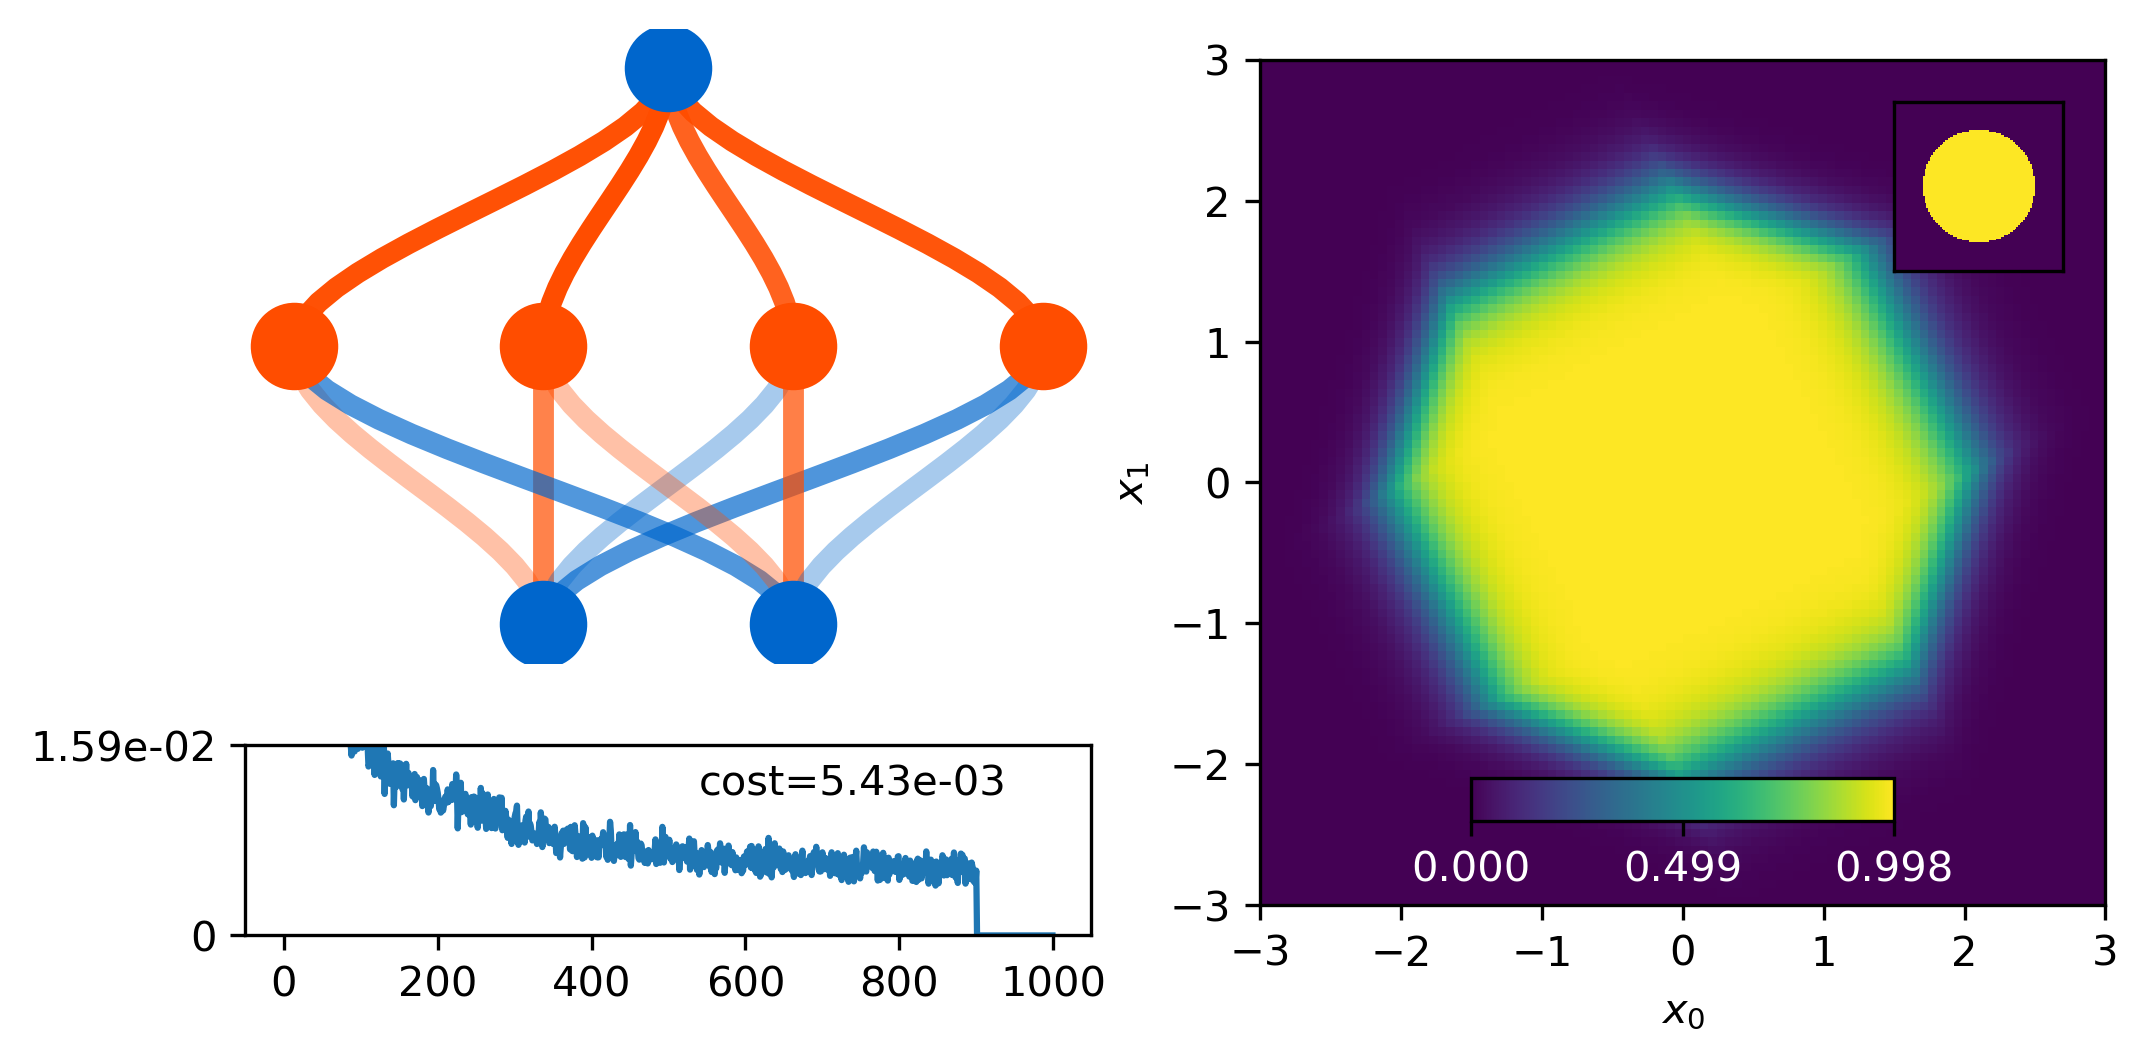

Summary Stats: Circle Run 1

Cost function: 0.005597566879609399
Network Complexity (fit parameters): 17
Execution Time (s): 9.265066703999992


In [6]:
run_name = "Circle Run 1"
num_n = [2,4,1]
bias_s = 1
weight_s = 1
target_f=circle_target
act = ['reLU','sigmoid',]
st = 1000
et = 5
batchs = 1000
visual = 100
run_training(run_name, num_n, bias_s, weight_s, target_f, act, st, et, batchs)

By far the best training was with reLU (inner layer), sigmoid (output). Labelling the activation functions as S(sigmoid), J(jump), L(linear) and R(reLU); the following were the results (decided not to show each output for the sake of brevity):
<p>SS: blurry triangle
<p>JJ: green screen
<p>LL: error returned
<p>RR: green screen
<p>SJ: green screen
<p>SL: error returned
<p>SR: green screen
<p>JS: yellow odd shaped four sided figure
<p>JL: error returned
<p>JR: green screen
<p>LS: no error, but just simple colour gradient, no shape
<p>LJ: green screen
<p>LR: error returned
<p>RS: well defined square in correct position, slightly blurred edges
<p>RJ: green screen
<p>RL: error returned
<p>RR: green square

Now this was repeated for 2 and 3 layer networks, although linear was excluded completely because of its obvious problems (probably because the range of the function is unlimited).

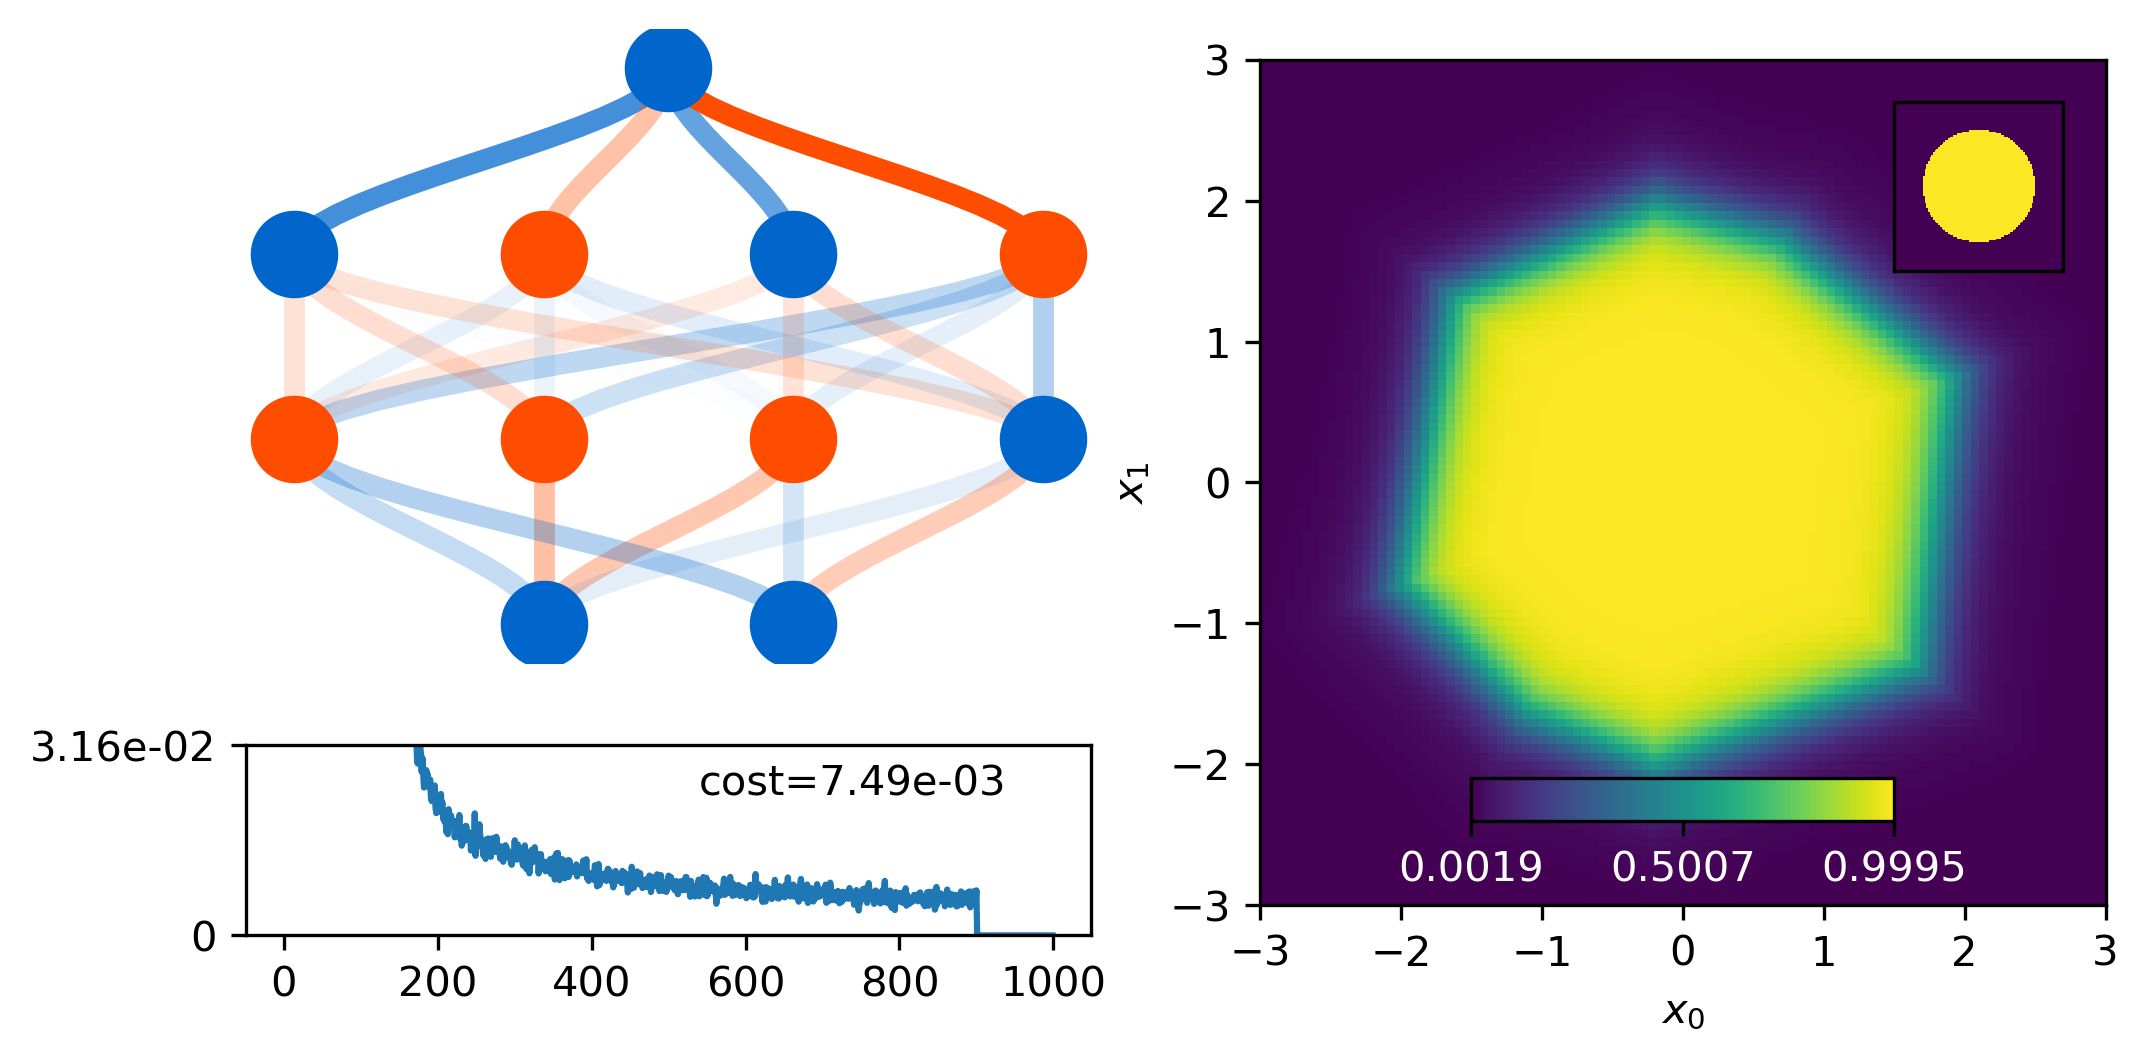

Summary Stats: Circle Run 2

Cost function: 0.006638046500942027
Network Complexity (fit parameters): 37
Execution Time (s): 10.329451687999992


In [7]:
run_name = "Circle Run 2"
num_n = [2,4,4,1]
bias_s = 1
weight_s = 1
target_f=circle_target
act = ['reLU','sigmoid','sigmoid',]
st = 1000
et = 5
batchs = 1000
visual = 100
run_training(run_name, num_n, bias_s, weight_s, target_f, act, st, et, batchs)

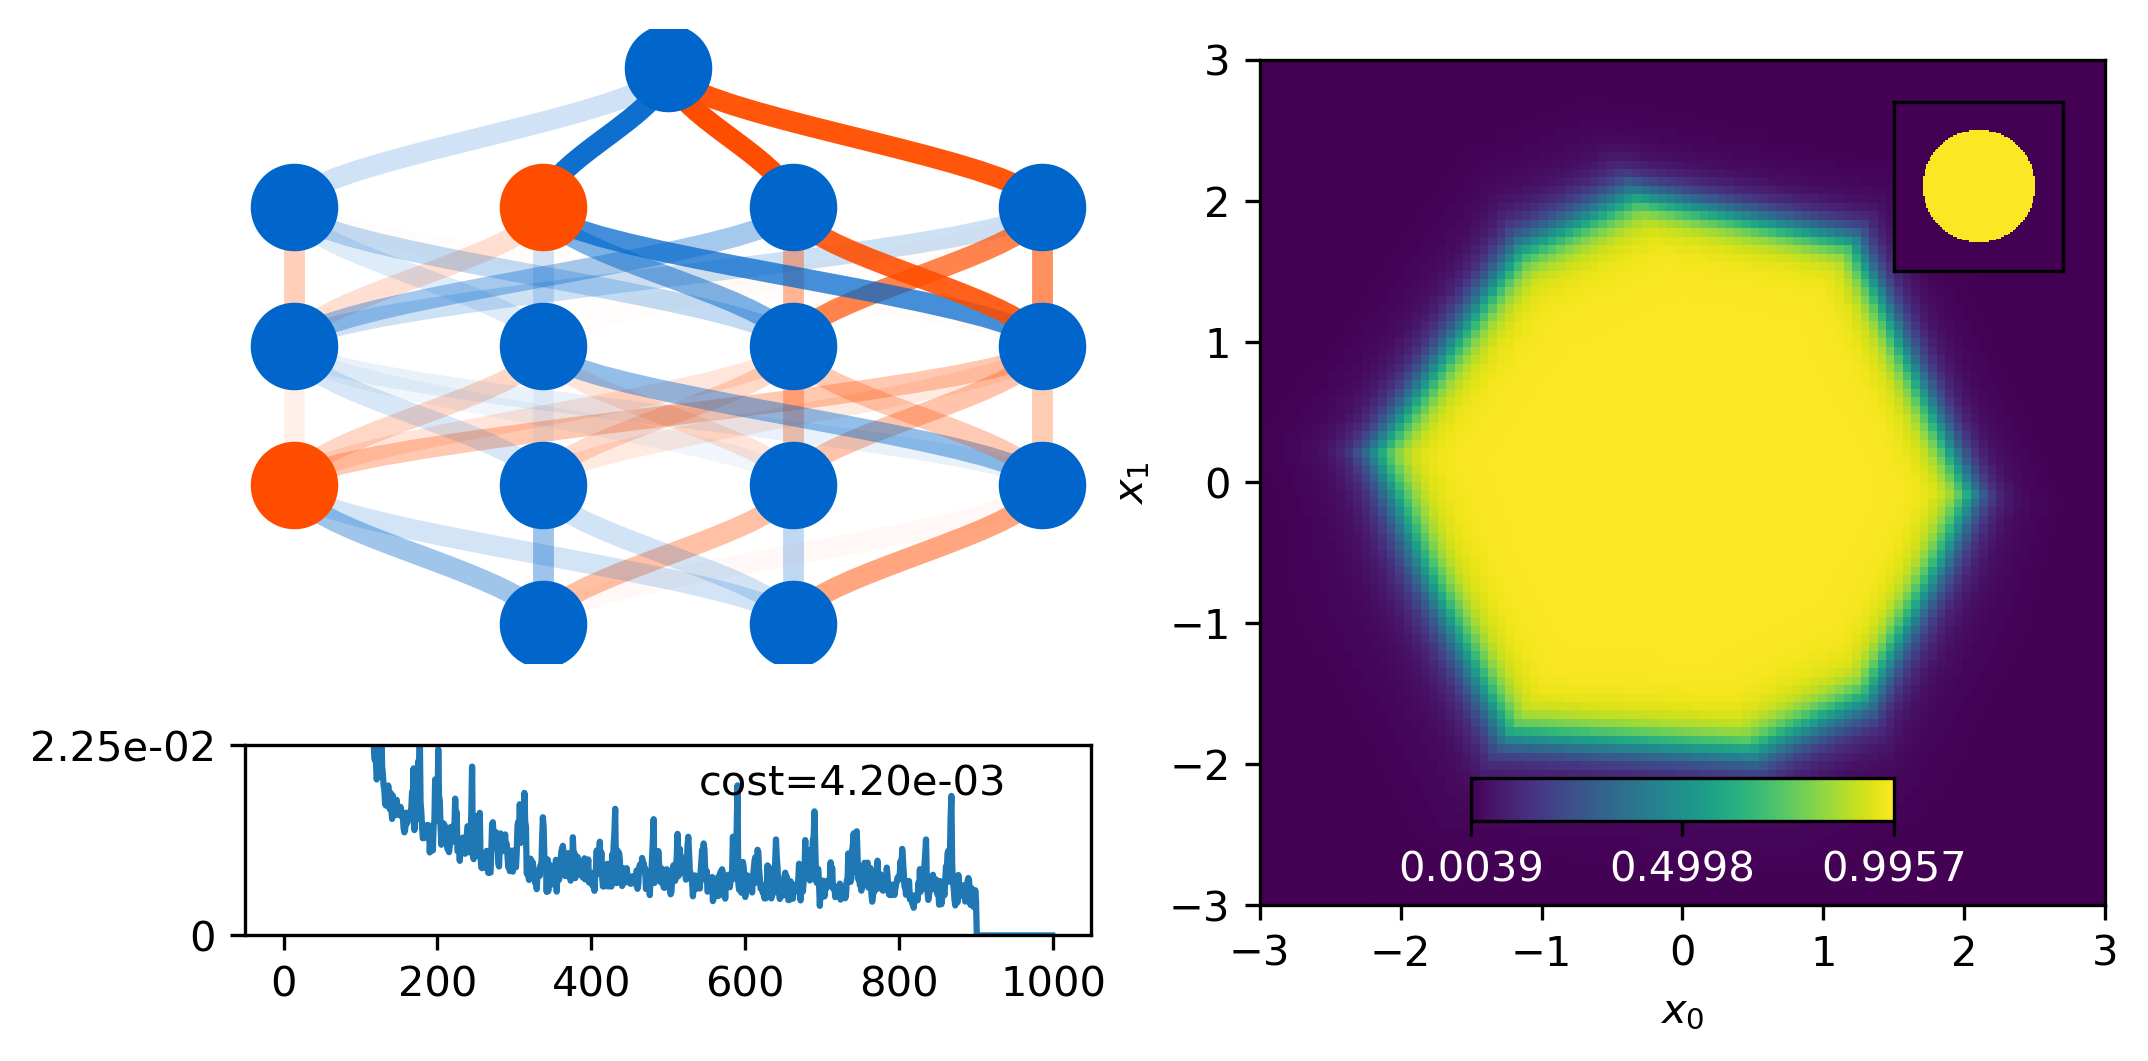

Summary Stats: Circle Run 3

Cost function: 0.005051843094566963
Network Complexity (fit parameters): 57
Execution Time (s): 11.087583523000006


In [8]:
run_name = "Circle Run 3"
num_n = [2,4,4,4,1]
bias_s = 1
weight_s = 1
target_f=circle_target
act = ['reLU','sigmoid','sigmoid','sigmoid']
st = 1000
et = 5
batchs = 1000
visual = 100
run_training(run_name, num_n, bias_s, weight_s, target_f, act, st, et, batchs)

# Discussion
In Circle Run 2, 3 above; by far the best results were obtained with the first hidden layer having reLU activation function and then all the following having sigmoid activation function. These parameters were fixed for the rest of the trainings. The network complexity increased from Run 1 (17) to Run 2(37) to Run 3 (57) and the fit got better moving from a square to a hexagon to shape with more sides (although this did vary on repetition). Clearly more nodes were required, but also a methodology was needed to compare one layer networks to 2,3,4 or even more layer networks with similar network complexities. The code cell below allows quick calculation of the network complexity. This would help calibration of network complexity for different numbers of layers. 

It was decided to start with one inner layer and make it wide: 60 nodes. From *Week 1: Visualizing Neural Networks with Pure Python*, circles or pairs of circles had been developed using one wide hiden layer. 60 was chosen as it is a number which factorizes nicely, so the width could be made 1/2, 1/3, 1/4, 1/5, 1/6 of its starting width. Then the other variables were altered (not target_f or activation functions) until a decent fit was obtained after a reasonable amount of time c.16s. The bias, weight scale, $\eta$ and batches were altered to do this in Run 4 (not shown) and then the value selected were kept constant for the rest of the trainings as they could be altered later once the right network shape and complexity were sorted. It was noted that having a too large $\eta$ and too small number of batches was a bad combination and one which caused a lot of volatility in the cost function.

Then other runs were made with two inner layers: first layer twice as wide as second layer, then second layer twice as wide as first layer, then equally weighted. Finally a run with three equal layers was made. The width of layers was calibrated using the code cell below, so that the compexity remained at a similar level in the different runs. 

In [9]:
num_n = [2,10,10,10,1]
bias_num = np.sum(num_n[1:])#number of biases is total number of nodes excluding first layer
weights_num = np.sum([(num_n[j+1]*num_n[j]) for j in range (len(num_n)-1)])
print(bias_num + weights_num)

261


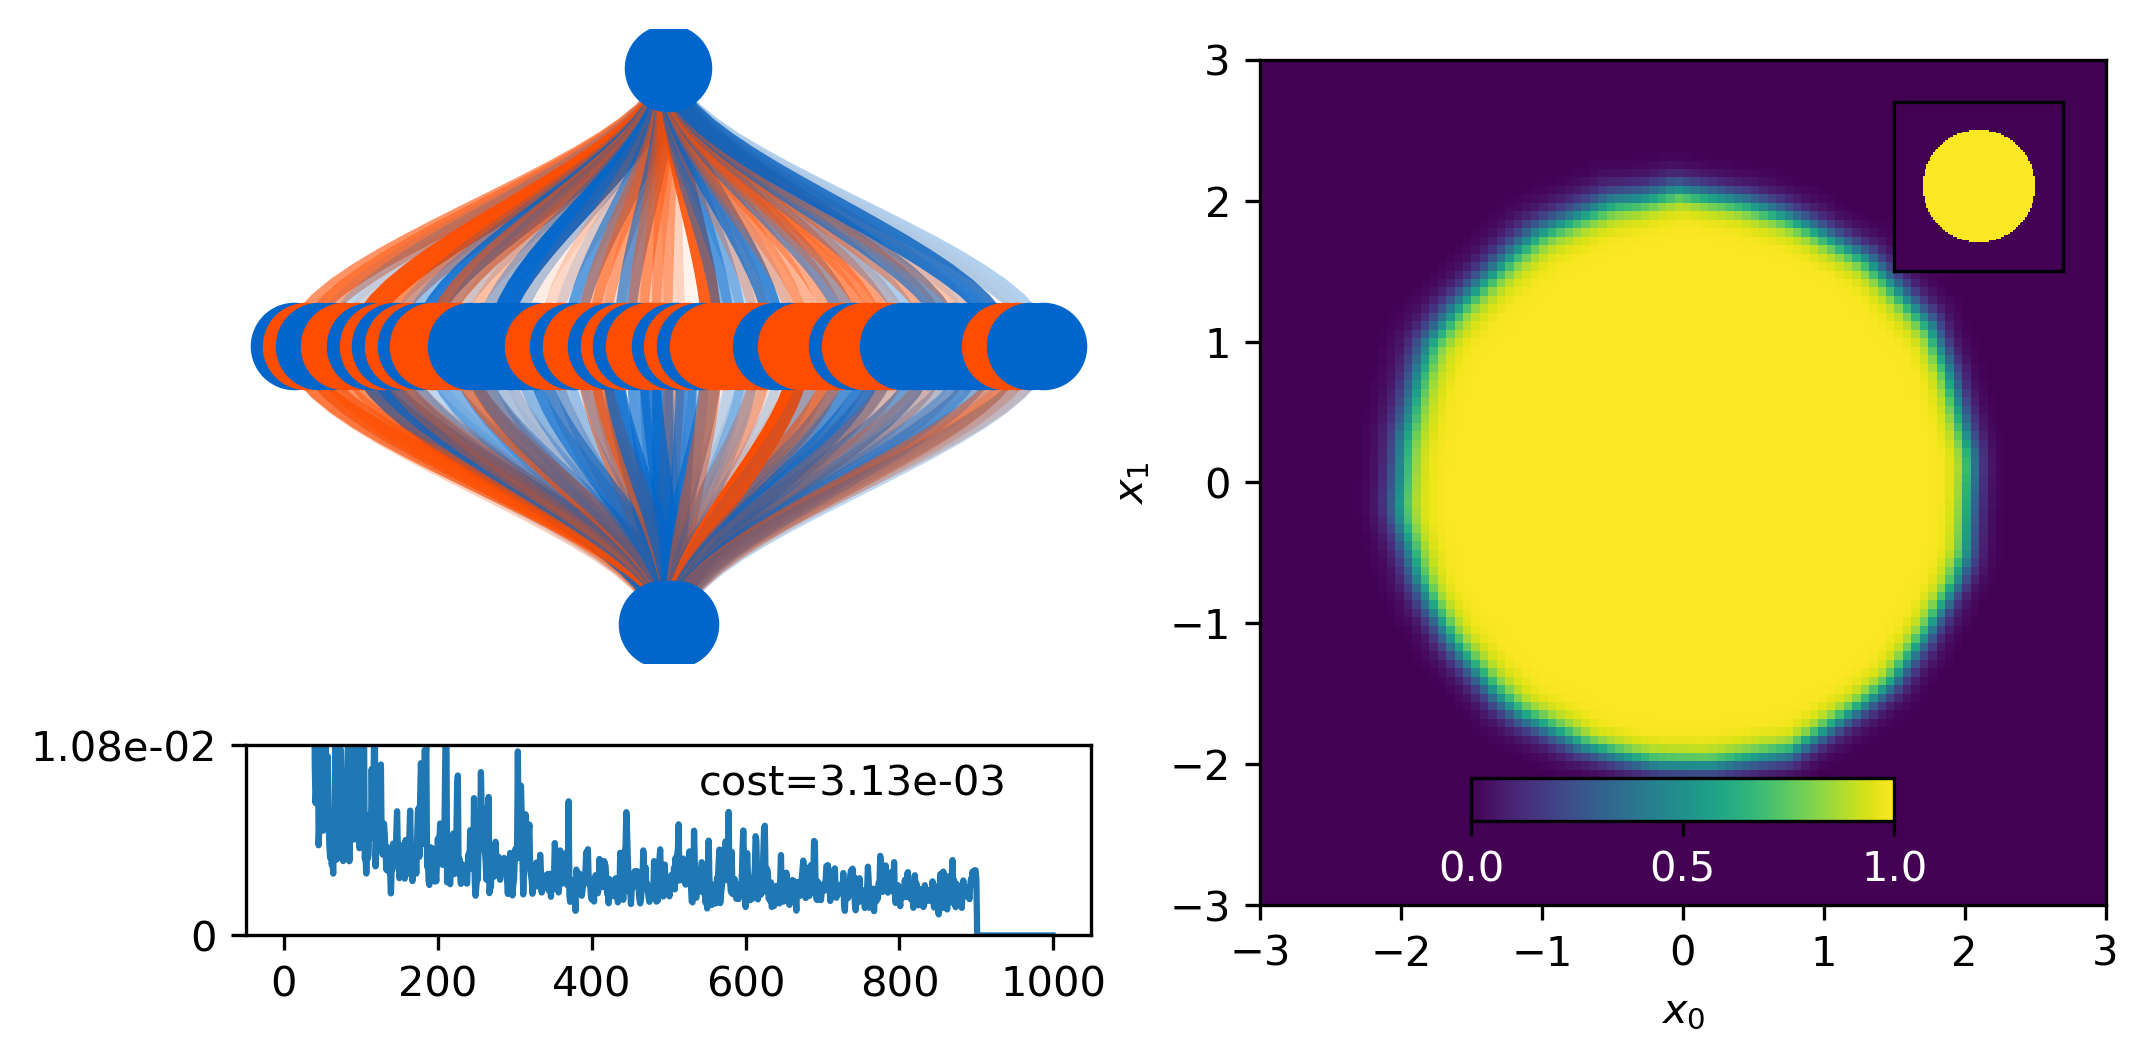

Summary Stats: Circle Run 4

Cost function: 0.0017571291766201264
Network Complexity (fit parameters): 241
Execution Time (s): 16.145133083999994


In [10]:
run_name = "Circle Run 4"
num_n = [2,60,1]
bias_s = 1
weight_s = 1
target_f=circle_target
act = ['reLU','sigmoid',]
st = 1000
et = 5
batchs = 1000
visual = 100
run_training(run_name, num_n, bias_s, weight_s, target_f, act, st, et, batchs)

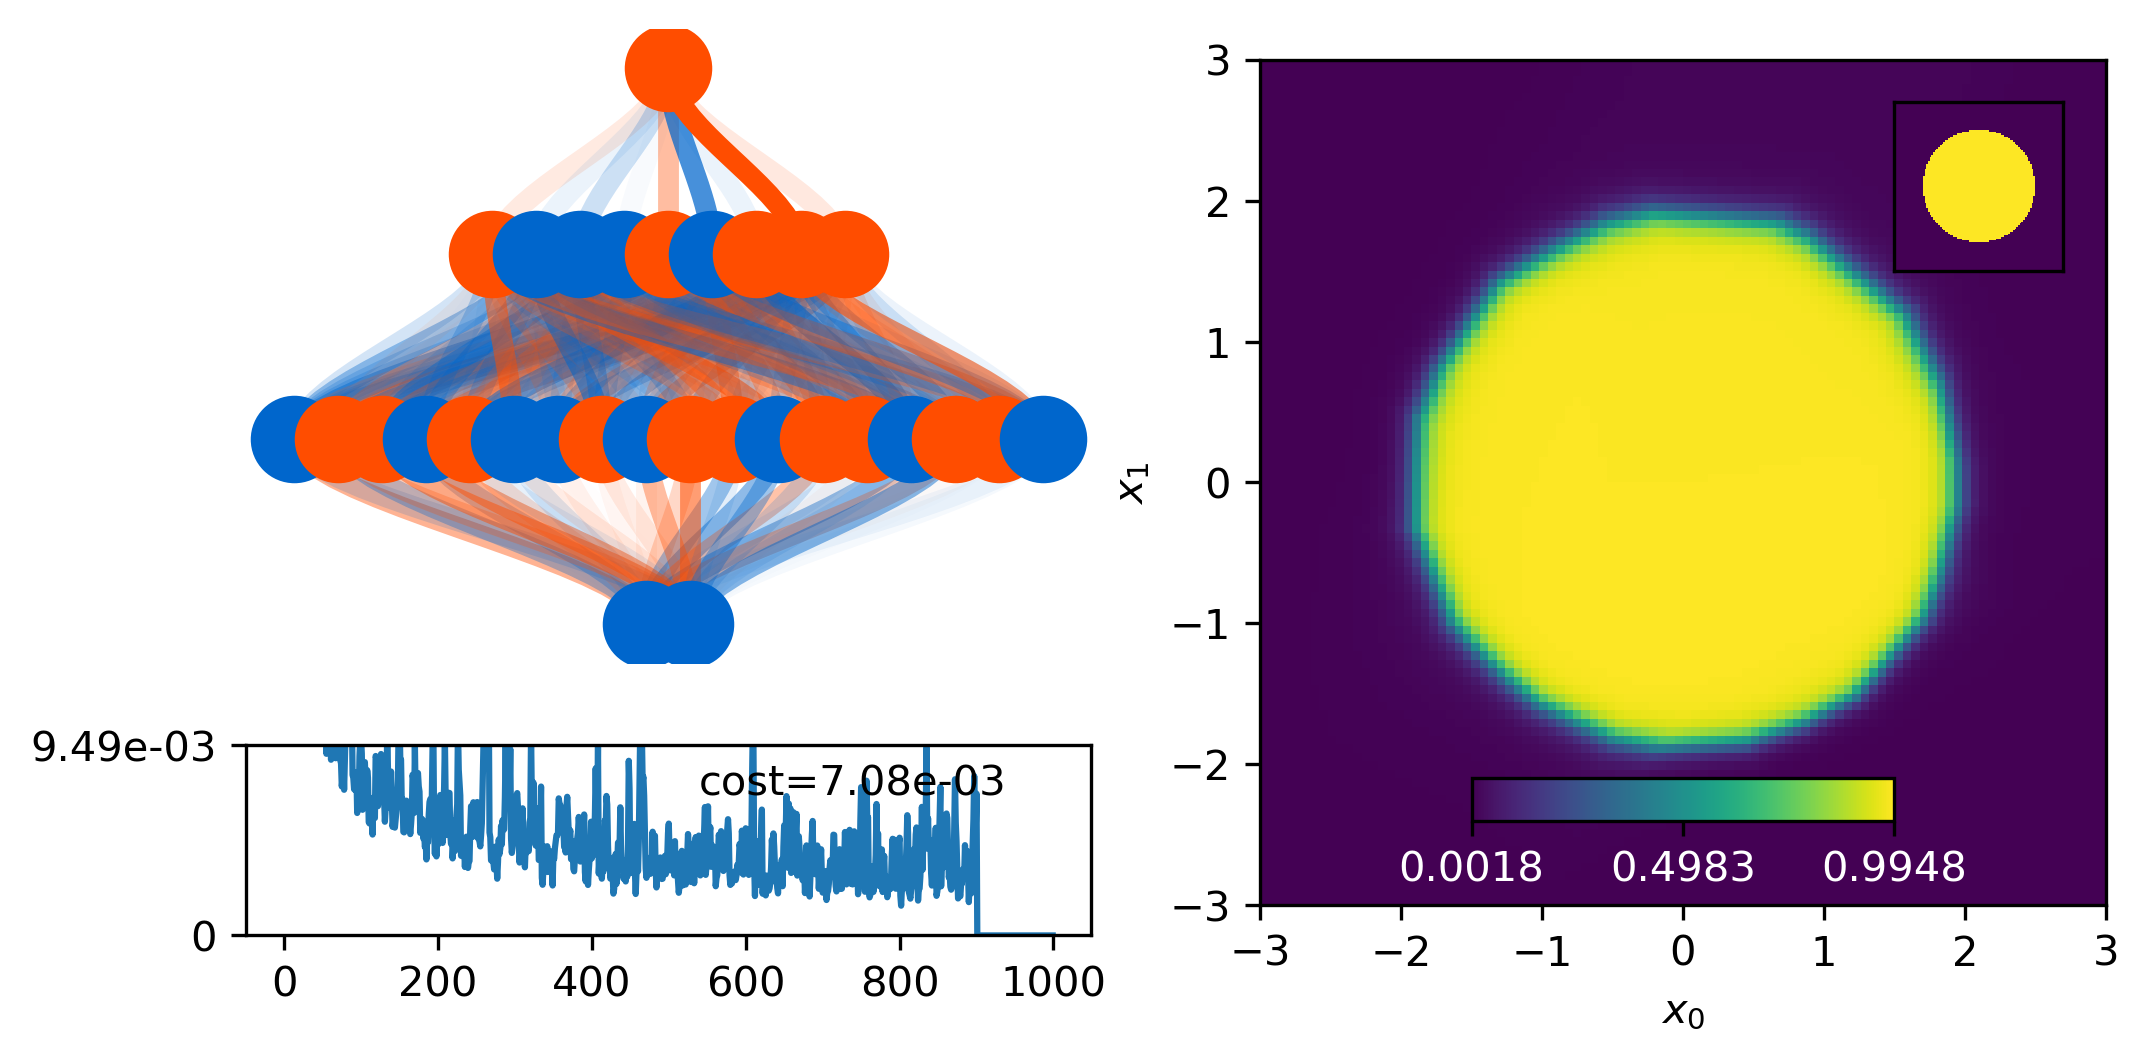

Summary Stats: Circle Run 5

Cost function: 0.006162826717176934
Network Complexity (fit parameters): 235
Execution Time (s): 14.94374388


In [11]:
run_name = "Circle Run 5"
num_n = [2,18,9,1]
bias_s = 1
weight_s = 1
target_f=circle_target
act = ['reLU','sigmoid','sigmoid',]
st = 1000
et = 5
batchs = 1000
visual = 100
run_training(run_name, num_n, bias_s, weight_s, target_f, act, st, et, batchs)

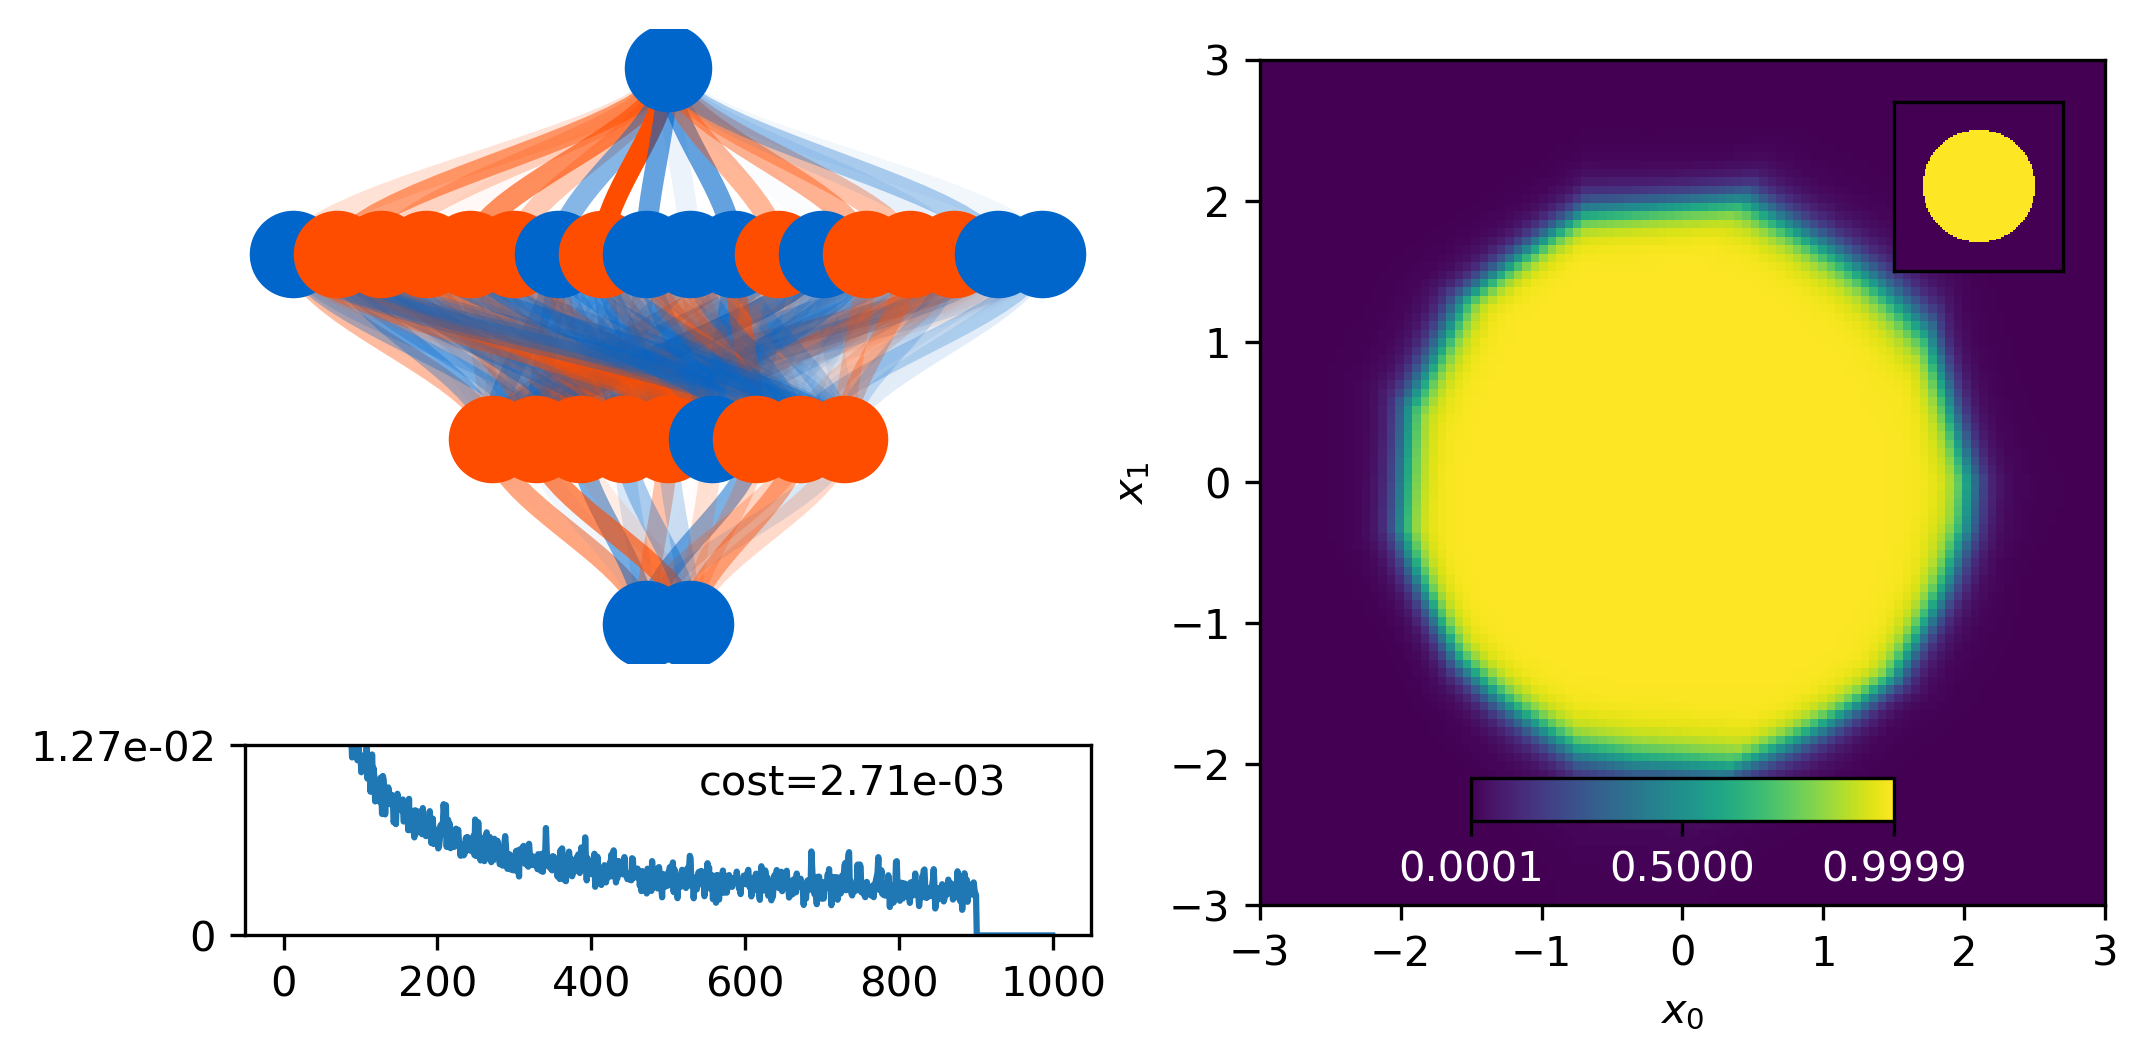

Summary Stats: Circle Run 6

Cost function: 0.0020583994796829655
Network Complexity (fit parameters): 226
Execution Time (s): 15.668214659


In [12]:
run_name = "Circle Run 6"
num_n = [2,9,18,1]
bias_s = 1
weight_s = 1
target_f=circle_target
act = ['reLU','sigmoid','sigmoid',]
st = 1000
et = 5
batchs = 1000
visual = 100
run_training(run_name, num_n, bias_s, weight_s, target_f, act, st, et, batchs)

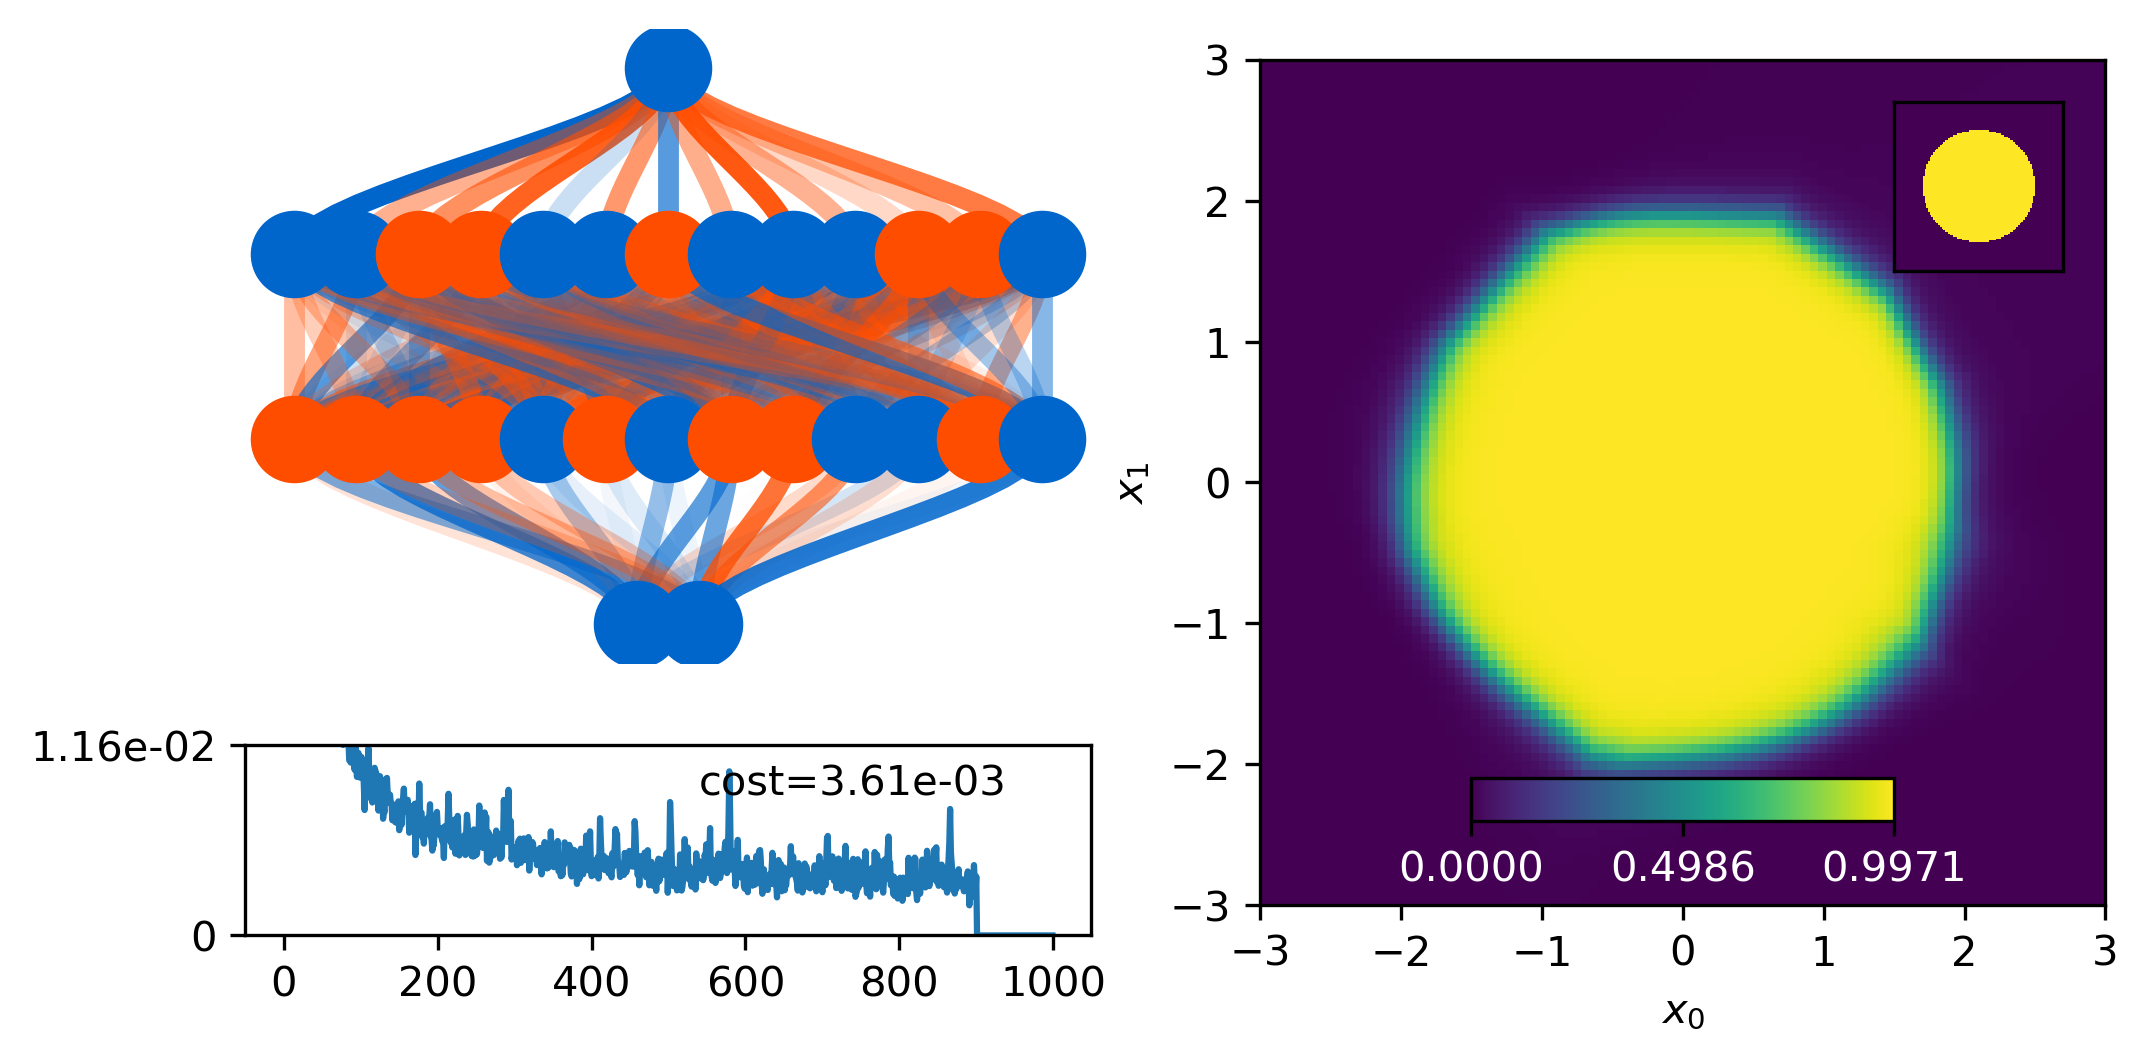

Summary Stats: Circle Run 7

Cost function: 0.0030425466960606567
Network Complexity (fit parameters): 235
Execution Time (s): 15.251095776


In [13]:
run_name = "Circle Run 7"
num_n = [2,13,13,1]
bias_s = 1
weight_s = 1
target_f=circle_target
act = ['reLU','sigmoid','sigmoid',]
st = 1000
et = 5
batchs = 1000
visual = 100
run_training(run_name, num_n, bias_s, weight_s, target_f, act, st, et, batchs)

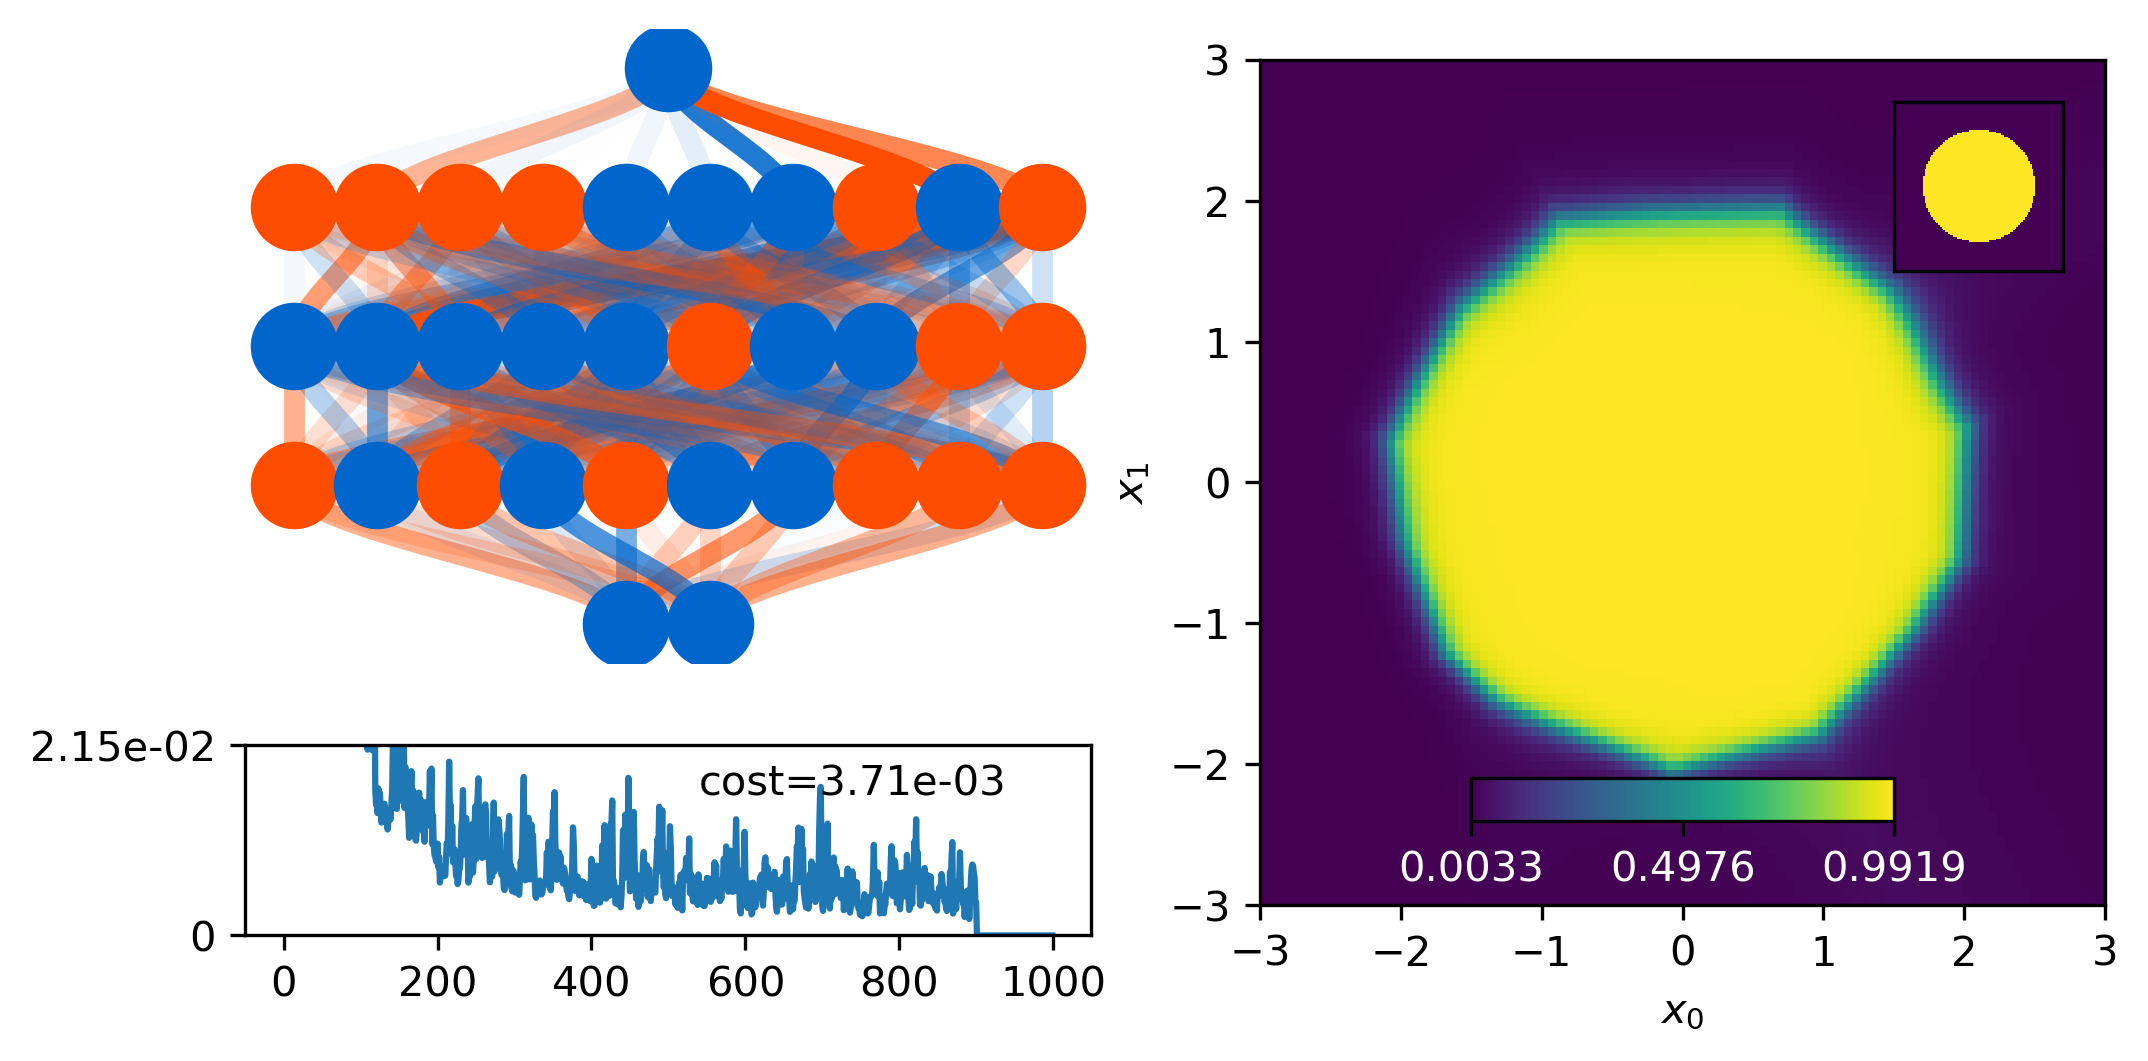

Summary Stats: Circle Run 8

Cost function: 0.004083825943632519
Network Complexity (fit parameters): 261
Execution Time (s): 17.139121199000016


In [14]:
run_name = "Circle Run 8"
num_n = [2,10,10,10,1]
bias_s = 1
weight_s = 1
target_f=circle_target
act = ['reLU','sigmoid','sigmoid','sigmoid',]
st = 1000
et = 5
batchs = 1000
visual = 100
run_training(run_name, num_n, bias_s, weight_s, target_f, act, st, et, batchs)

# Discussion
Execution times did not vary much between runs, which makes sense as the network complexity was held roughly constant over the runs.
There seems to be little advantage in adding extra layers for this target function. Usually, cost functions were worse for the multi-layer neural networks. It was decided to use one layer and see if we could reduce its width.

Execution times depend on the computer's speed and so can only be used as a relative measure. Network complexity is a measure which is not dependent on the computer the training is run on.

Now it was decided to reduce the width of the hidden layer and see if network complexity and execution time could be improved without compromising too much on cost function.

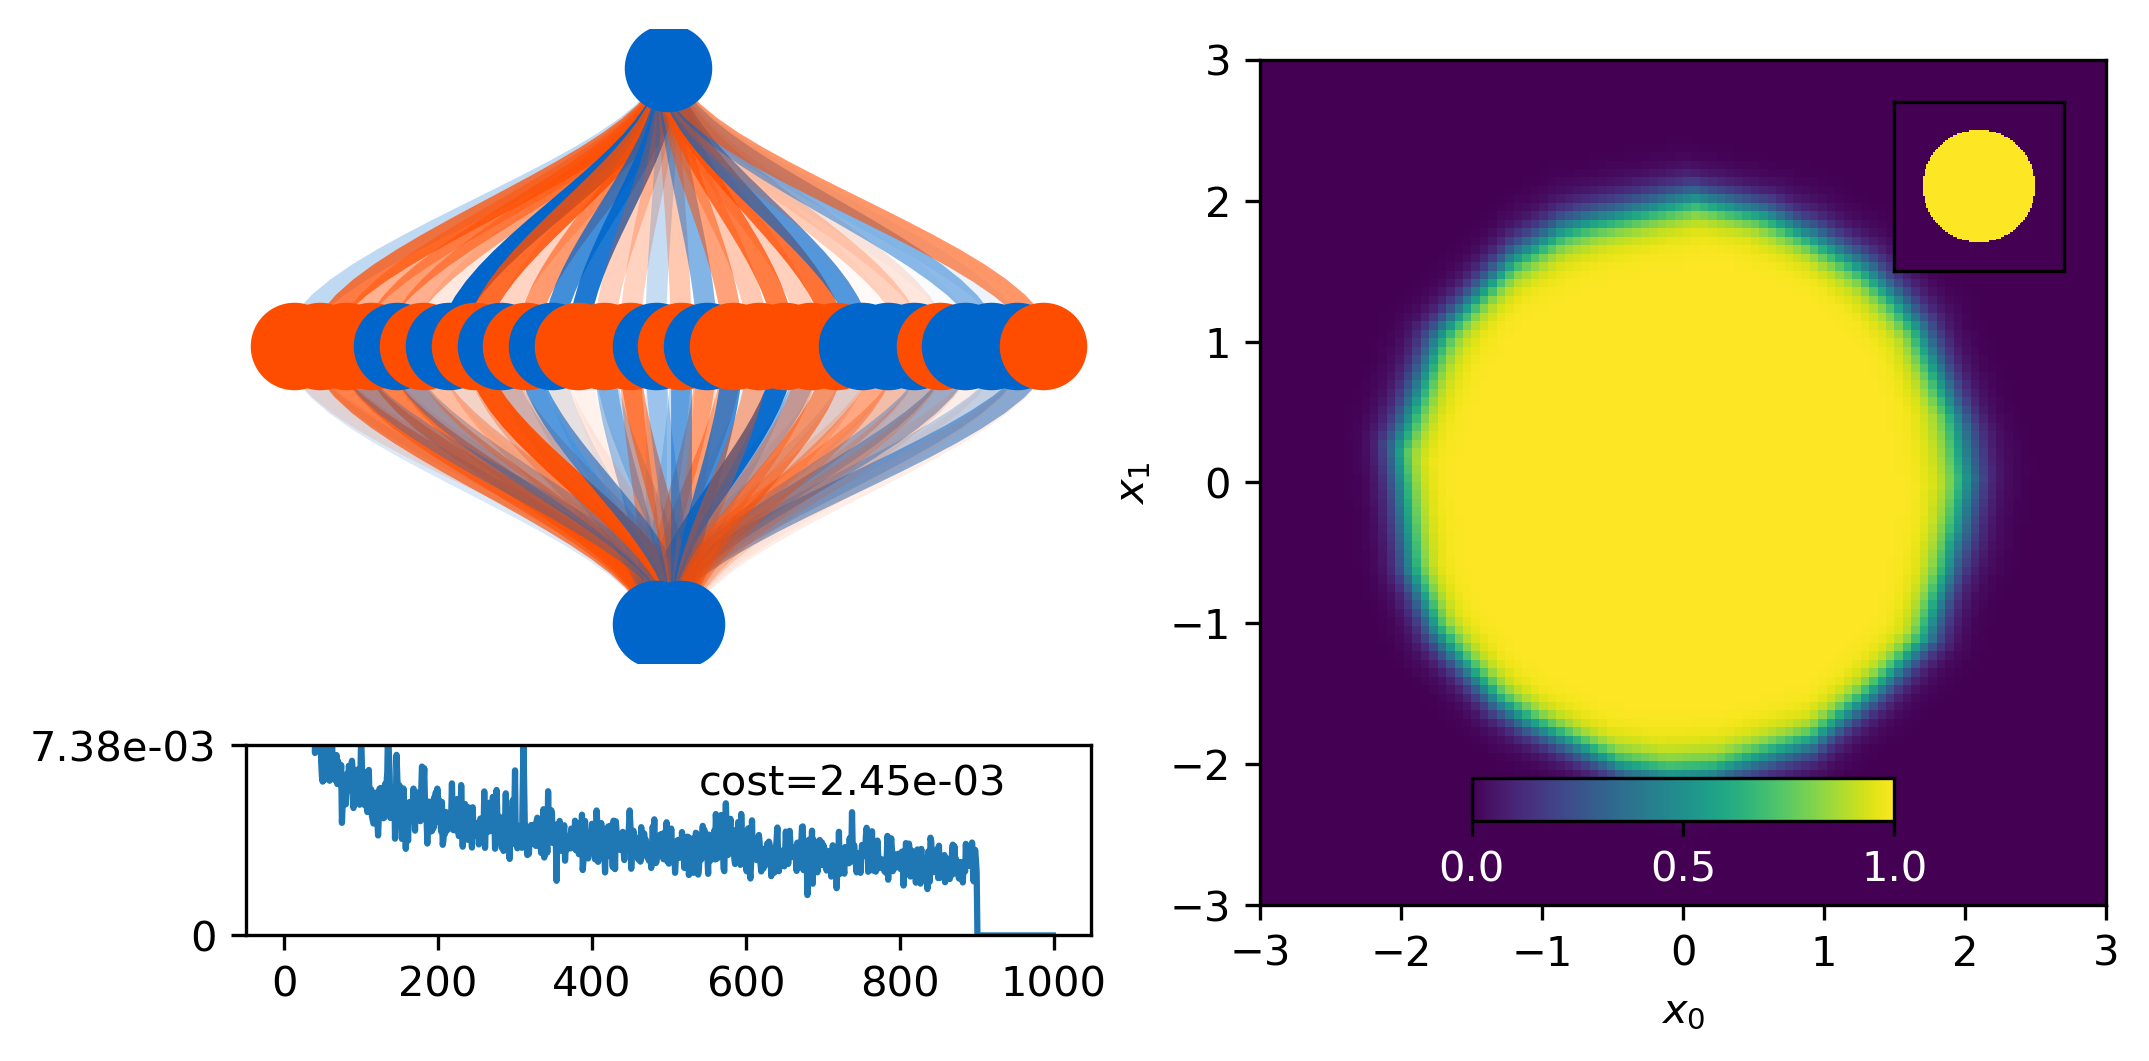

Summary Stats: Circle Run 9

Cost function: 0.0032619410141114216
Network Complexity (fit parameters): 121
Execution Time (s): 12.563557057000025


In [15]:
run_name = "Circle Run 9"
num_n = [2,30,1]
bias_s = 1
weight_s = 1
target_f=circle_target
act = ['reLU','sigmoid',]
st = 1000
et = 5
batchs = 1000
visual = 100
run_training(run_name, num_n, bias_s, weight_s, target_f, act, st, et, batchs)

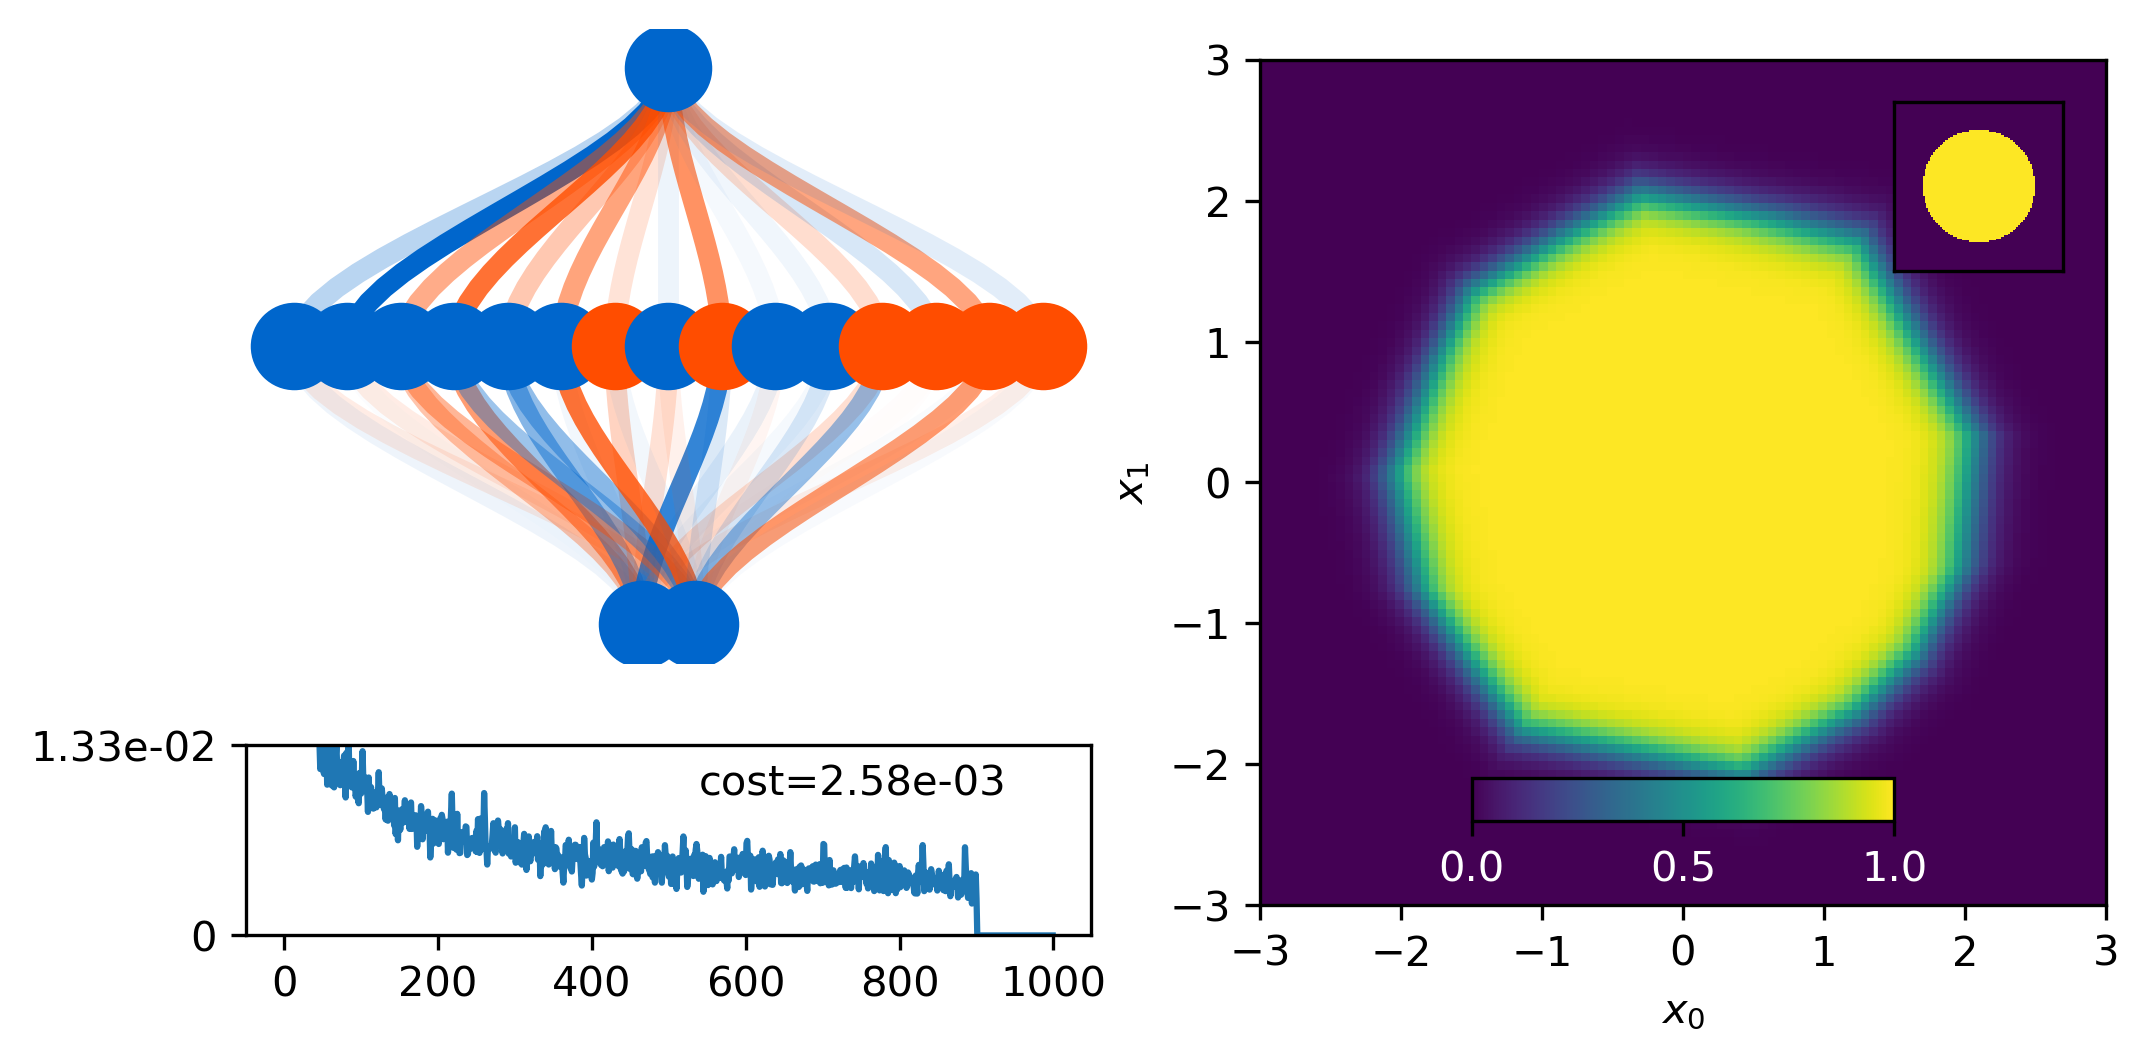

Summary Stats: Circle Run 10

Cost function: 0.0036229646686437352
Network Complexity (fit parameters): 61
Execution Time (s): 11.11760778499999


In [16]:
run_name = "Circle Run 10"
num_n = [2,15,1]
bias_s = 1
weight_s = 1
target_f=circle_target
act = ['reLU','sigmoid',]
st = 1000
et = 5
batchs = 1000
visual = 100
run_training(run_name, num_n, bias_s, weight_s, target_f, act, st, et, batchs)

# Discussion
It was decided that the cost function should be less than 0.004 for a good fit. This was achieved for one layer of 30 nodes and offered a significant reduction in network complexity (from 241 to 121) and reduction in execution time to 12 seconds. If one were to narrow the hidden layer further, cost function gets worse but complexity and execution times improve. In a sense, there is no right answer to this, which is why the threshold of cost function < 0.004 was set. Finally it was noted that the cost function flattens so a final run was made with 800 instead of 1000 steps.

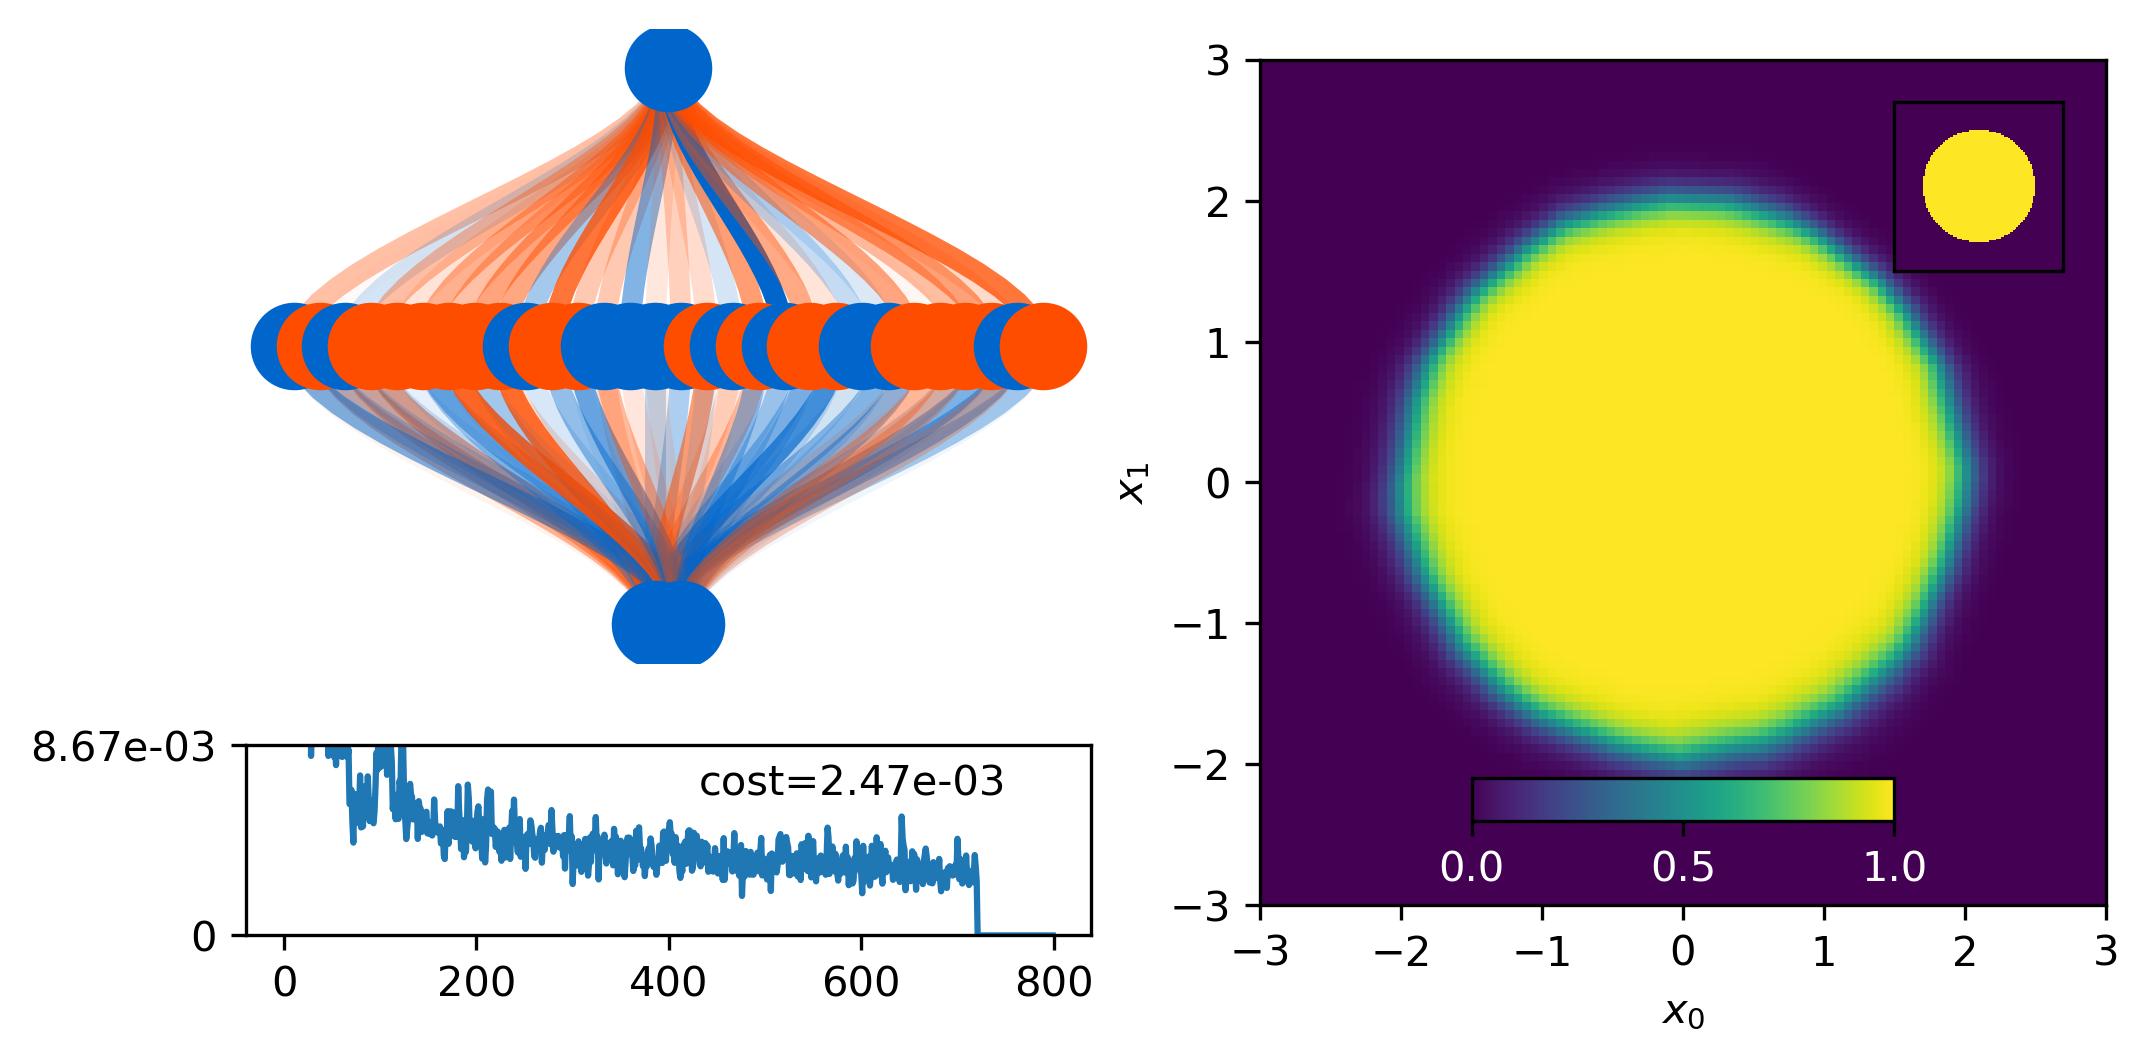

Summary Stats: Circle Run 11 - selected training parameters

Cost function: 0.002523481730328867
Network Complexity (fit parameters): 121
Execution Time (s): 11.552786803999993


In [17]:
run_name = "Circle Run 11 - selected training parameters"
num_n = [2,30,1]
bias_s = 1
weight_s = 1
target_f=circle_target
act = ['reLU','sigmoid',]
st = 800
et = 5
batchs = 1000
visual = 80
run_training(run_name, num_n, bias_s, weight_s, target_f, act, st, et, batchs)

# Discussion
Above are my selected training parameters for the circle target (Run 11)

## Circle hole target [40 points]
Train a network to mimic the following target (e.g. using the visualize_network_training function above)

In [18]:
def circle_hole_target(x):#A circle of radius 2, with a hole of radius 1 around the origin
    r=1.0; R=2.0
    return( 1.0*( x[:,0]**2+x[:,1]**2<R**2 ) - 1.0*( (x[:,0])**2+(x[:,1])**2<r**2))


# Discussion
In tackling the circle with hole, it was decided to use a single layer with 60 nodes as had been done previously. Here though, the number of steps and batchs had to be increased and $\eta$ decreased to get a decent fit and it took far longer (not surprising given the greater complexity of the target).

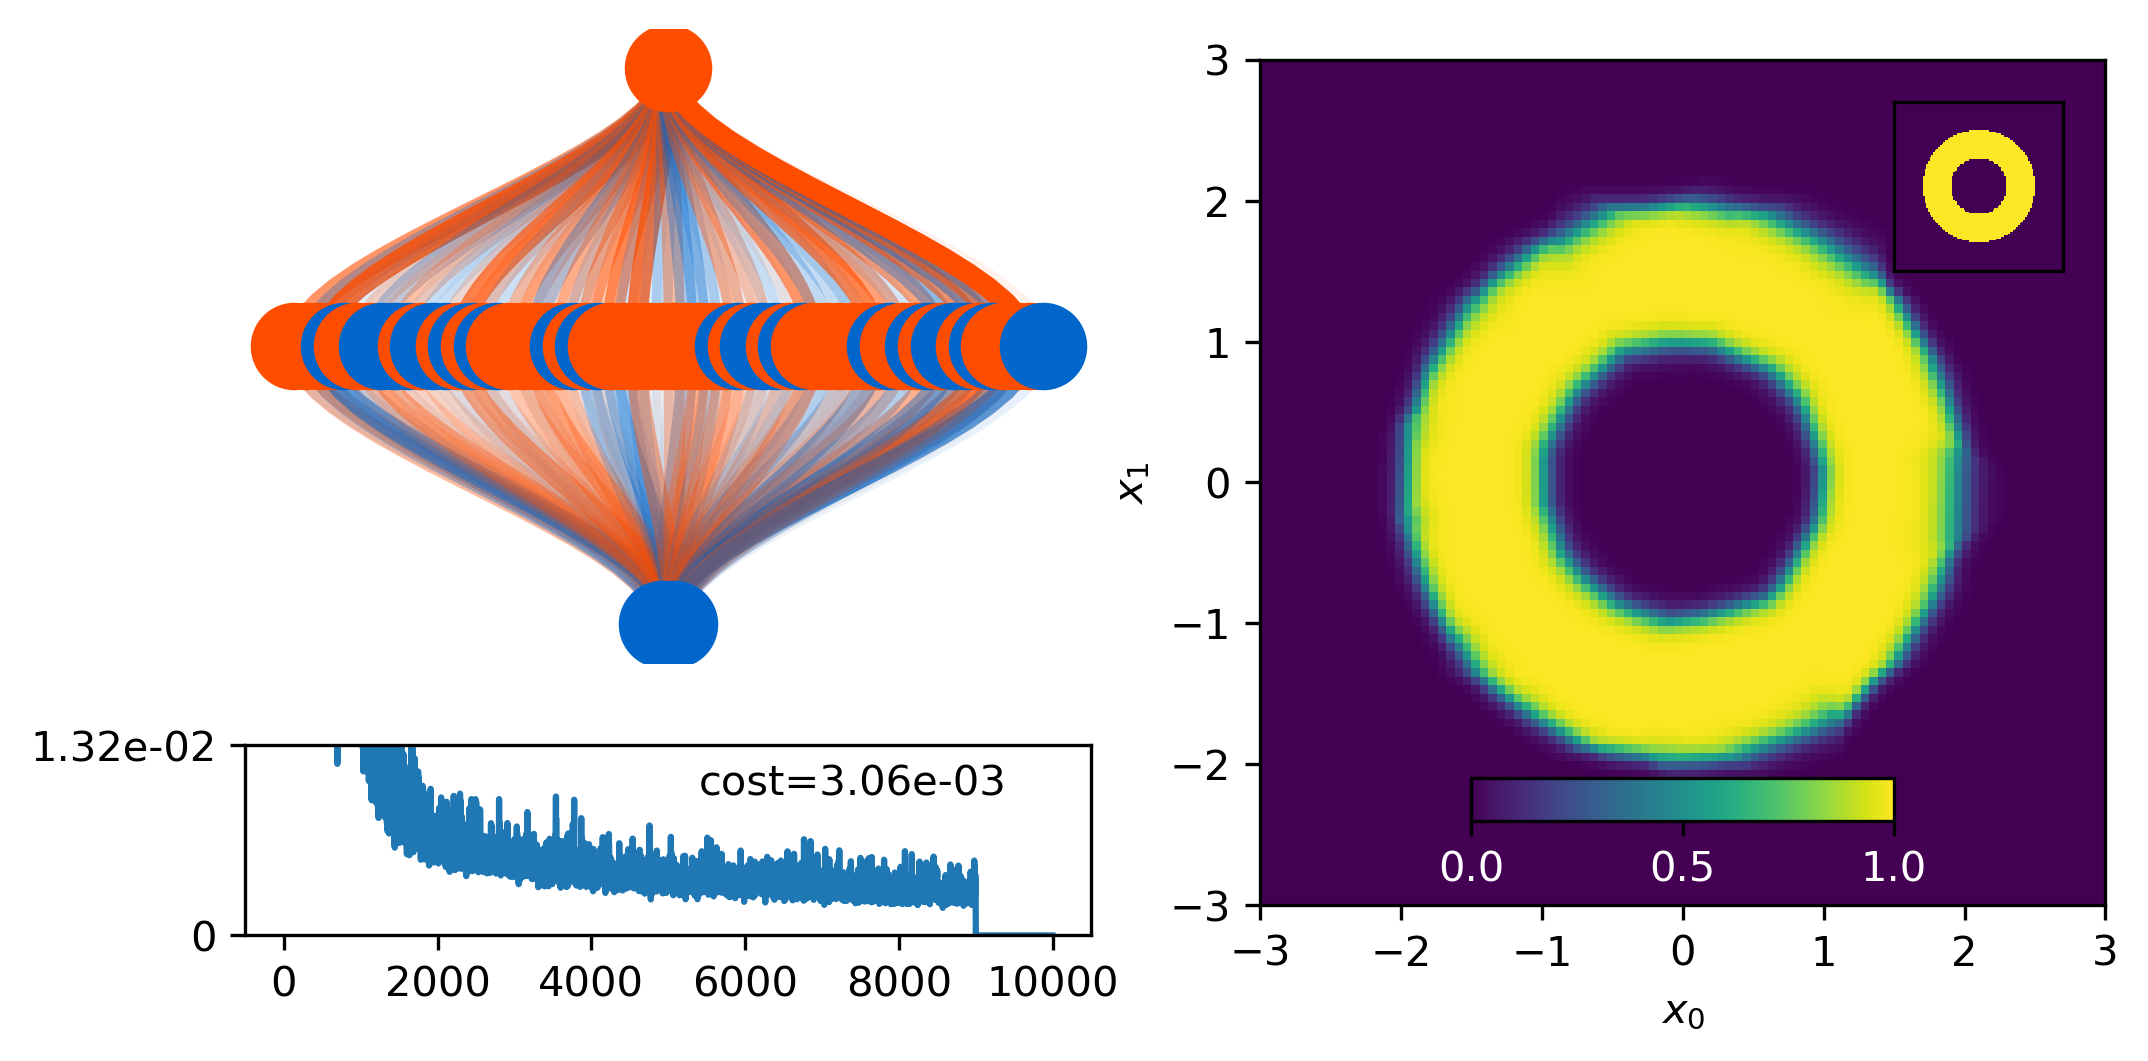

Summary Stats: Circle With Hole Run 1

Cost function: 0.0028590450105523556
Network Complexity (fit parameters): 241
Execution Time (s): 34.792815570000016


In [19]:
run_name = "Circle With Hole Run 1"
num_n = [2,60,1]
bias_s = 1
weight_s = 1
target_f=circle_hole_target
act = ['reLU','sigmoid']
st = 10000
et = 4
batchs = 2000
visual = 1000
run_training(run_name, num_n, bias_s, weight_s, target_f, act, st, et, batchs)


# Discussion
It was pleasing to see a low cost function, but the process took over half a minute. Next it was decided to try 3 and then 2 hidden layers of equal length of similar network complexity, keeping other parameters fixed.

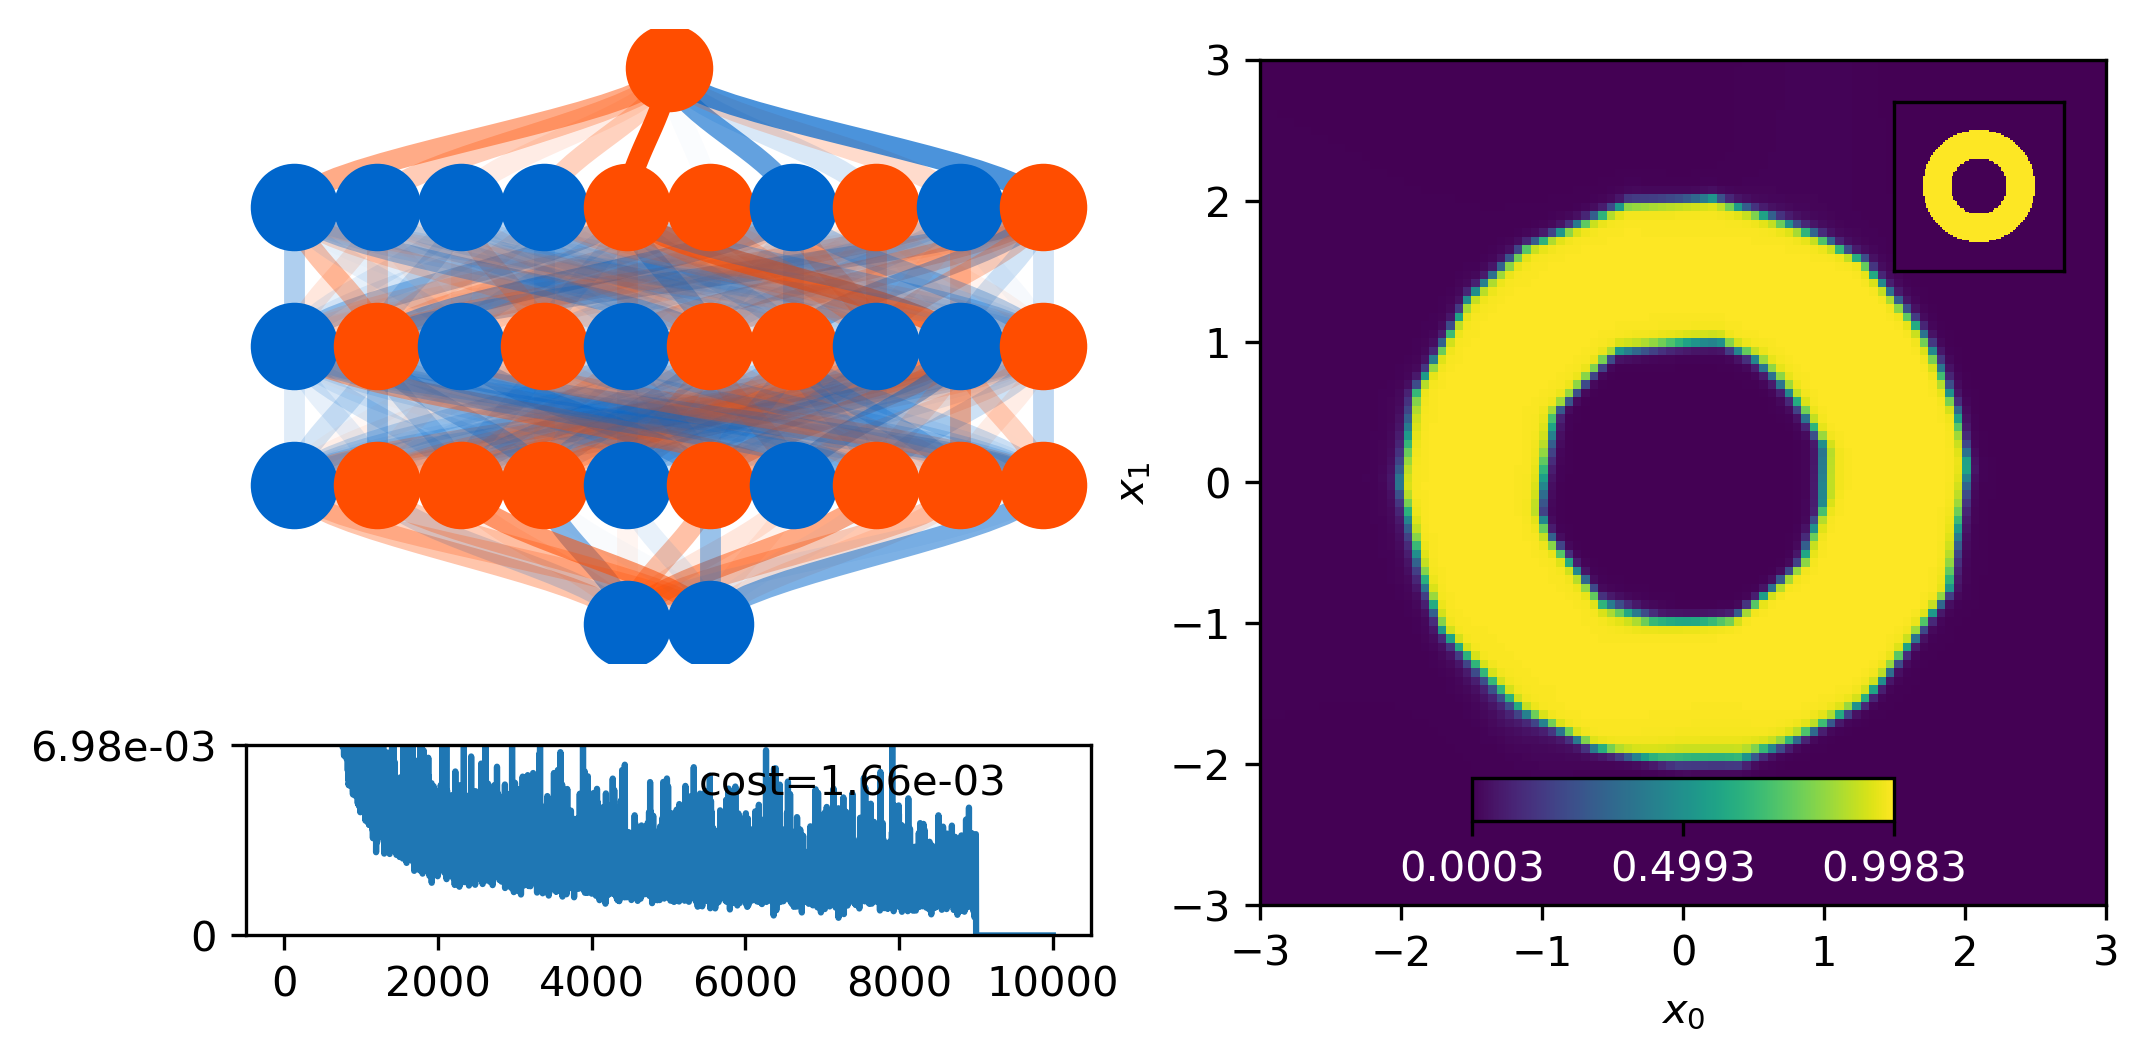

Summary Stats: Circle With Hole Run 2

Cost function: 0.00241010485859392
Network Complexity (fit parameters): 261
Execution Time (s): 46.77410360599998


In [20]:
run_name = "Circle With Hole Run 2"
num_n = [2,10,10,10,1]
bias_s = 1
weight_s = 1
target_f=circle_hole_target
act = ['reLU','sigmoid', 'sigmoid', 'sigmoid', 'sigmoid',]
st = 10000
et = 4
batchs = 2000
visual = 1000
run_training(run_name, num_n, bias_s, weight_s, target_f, act, st, et, batchs)

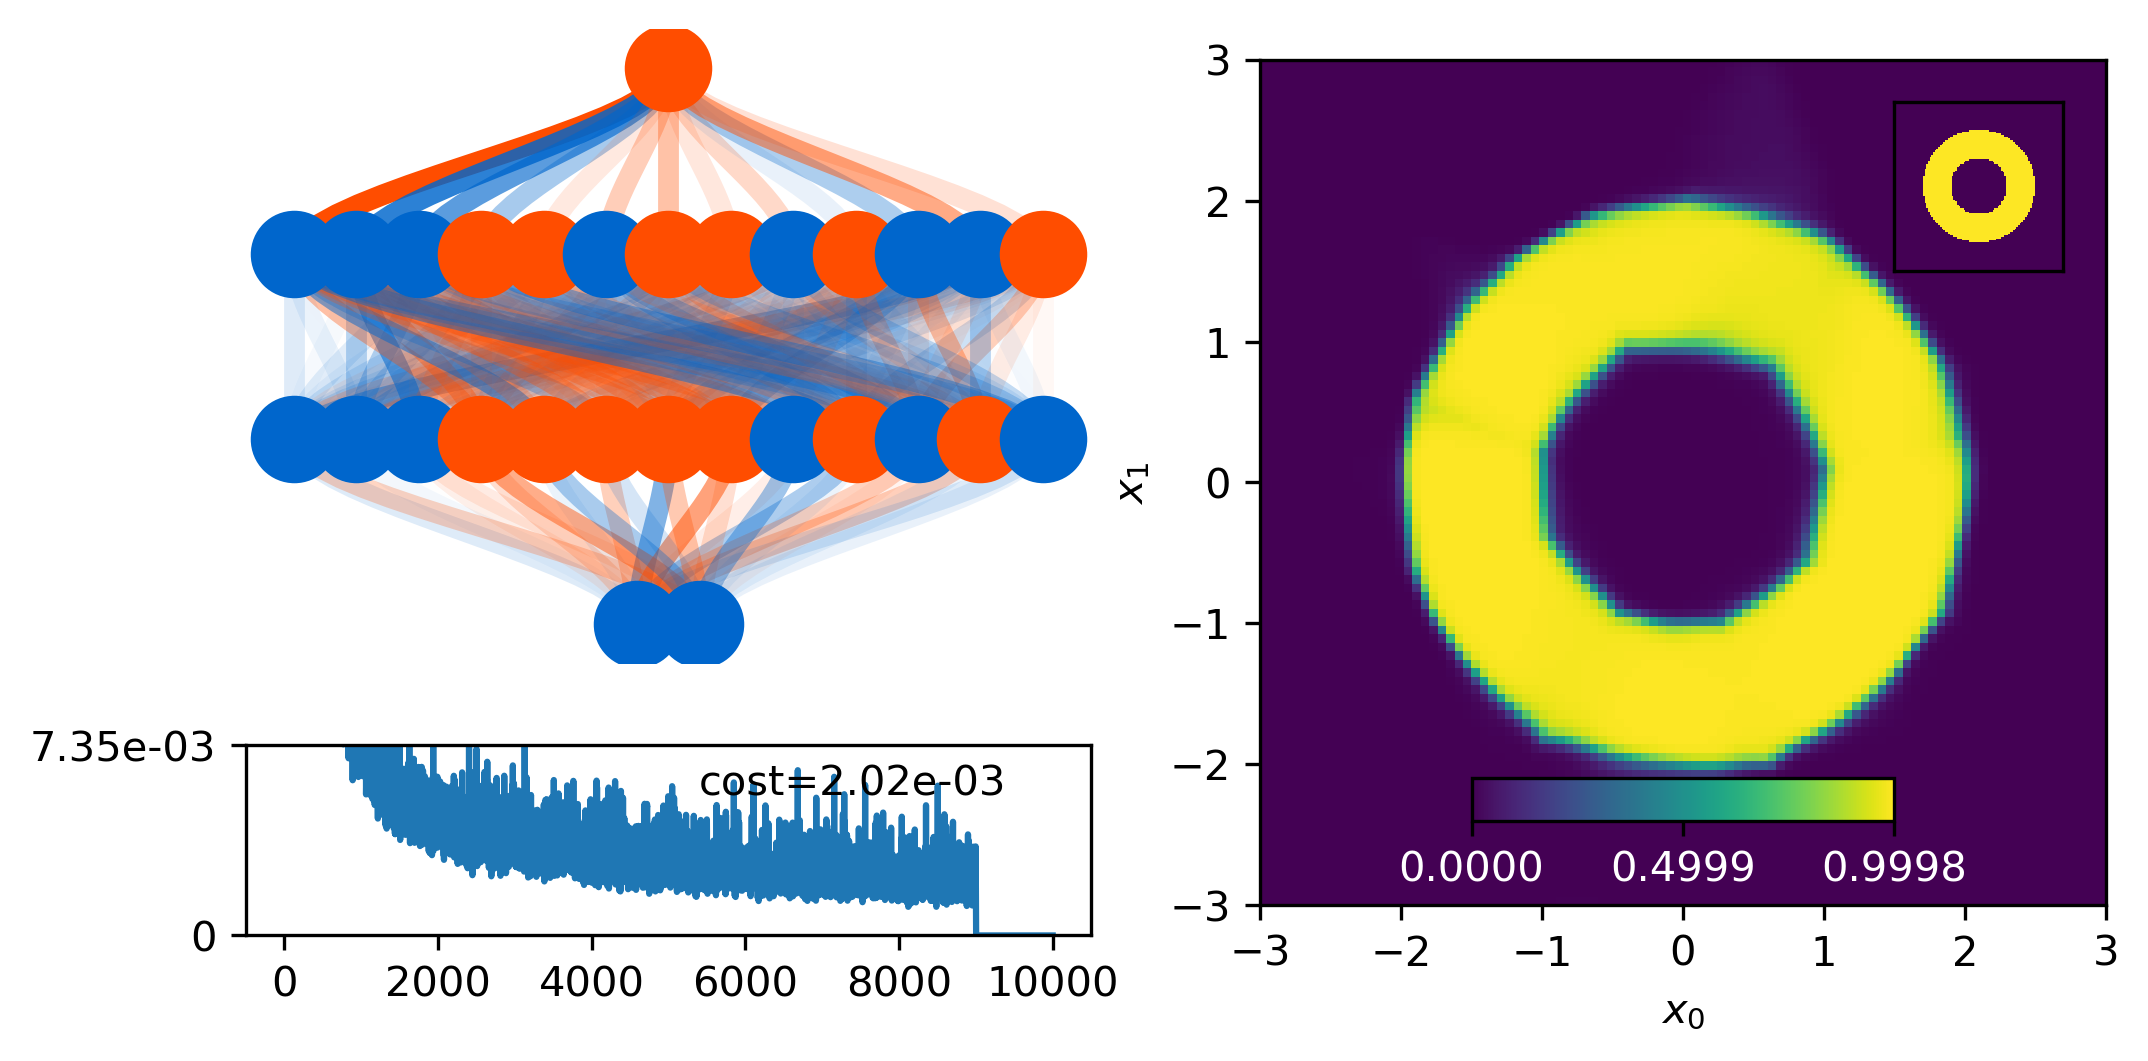

Summary Stats: Circle With Hole Run 3

Cost function: 0.0019935617805732194
Network Complexity (fit parameters): 235
Execution Time (s): 37.65744992599991


In [21]:
run_name = "Circle With Hole Run 3"
num_n = [2,13,13,1]
bias_s = 1
weight_s = 1
target_f=circle_hole_target
act = ['reLU','sigmoid', 'sigmoid', 'sigmoid',]
st = 10000
et = 4
batchs = 2000
visual = 1000
run_training(run_name, num_n, bias_s, weight_s, target_f, act, st, et, batchs)

# Discussion
For the circle with hole target, the two hidden layer network gave the best fit and was selected. Now it was tested with first layer twice as wide as second and then vice versa.

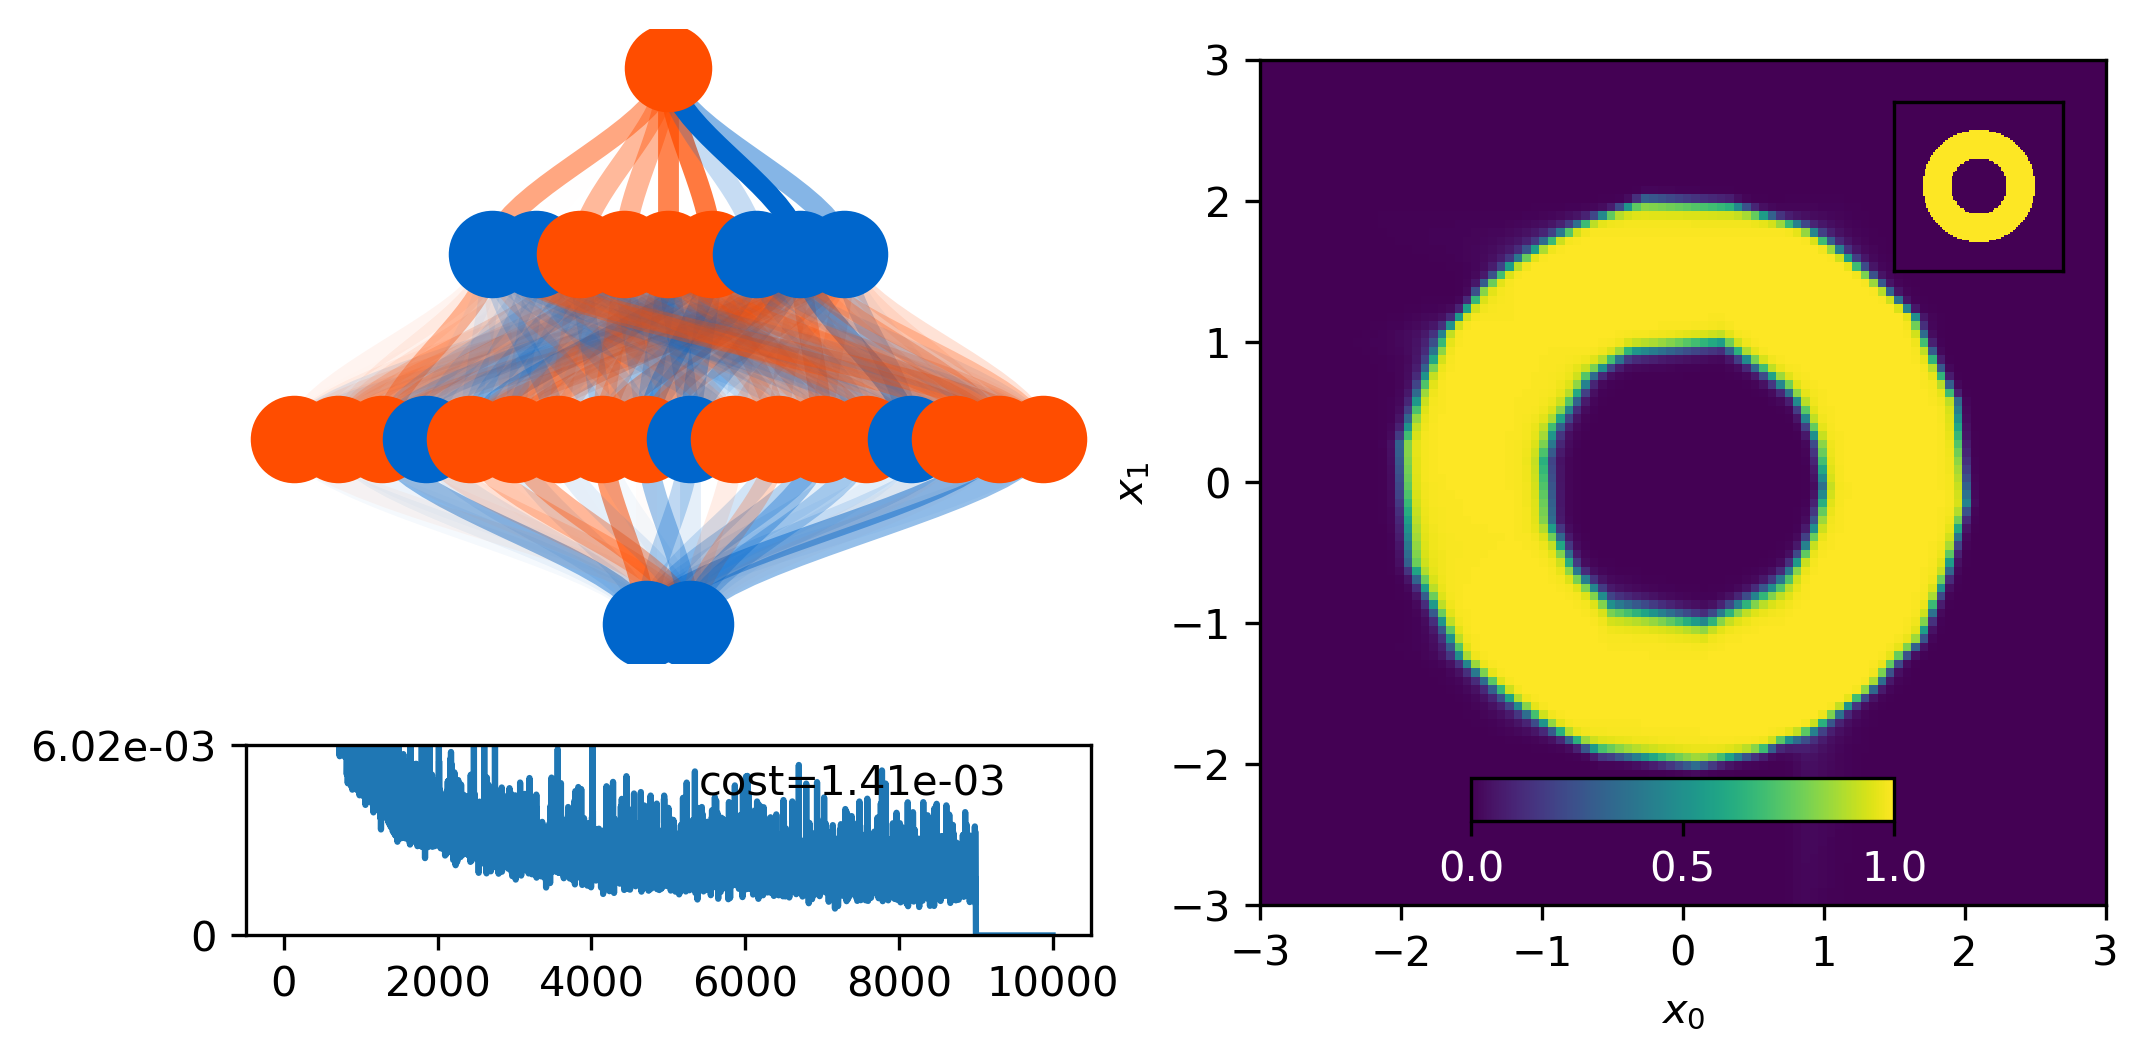

Summary Stats: Circle With Hole Run 4

Cost function: 0.0021832836147281875
Network Complexity (fit parameters): 235
Execution Time (s): 35.703564873999994


In [23]:
run_name = "Circle With Hole Run 4"
num_n = [2,18,9,1]
bias_s = 1
weight_s = 1
target_f=circle_hole_target
act = ['reLU','sigmoid', 'sigmoid', 'sigmoid',]
st = 10000
et = 4
batchs = 2000
visual = 1000
run_training(run_name, num_n, bias_s, weight_s, target_f, act, st, et, batchs)

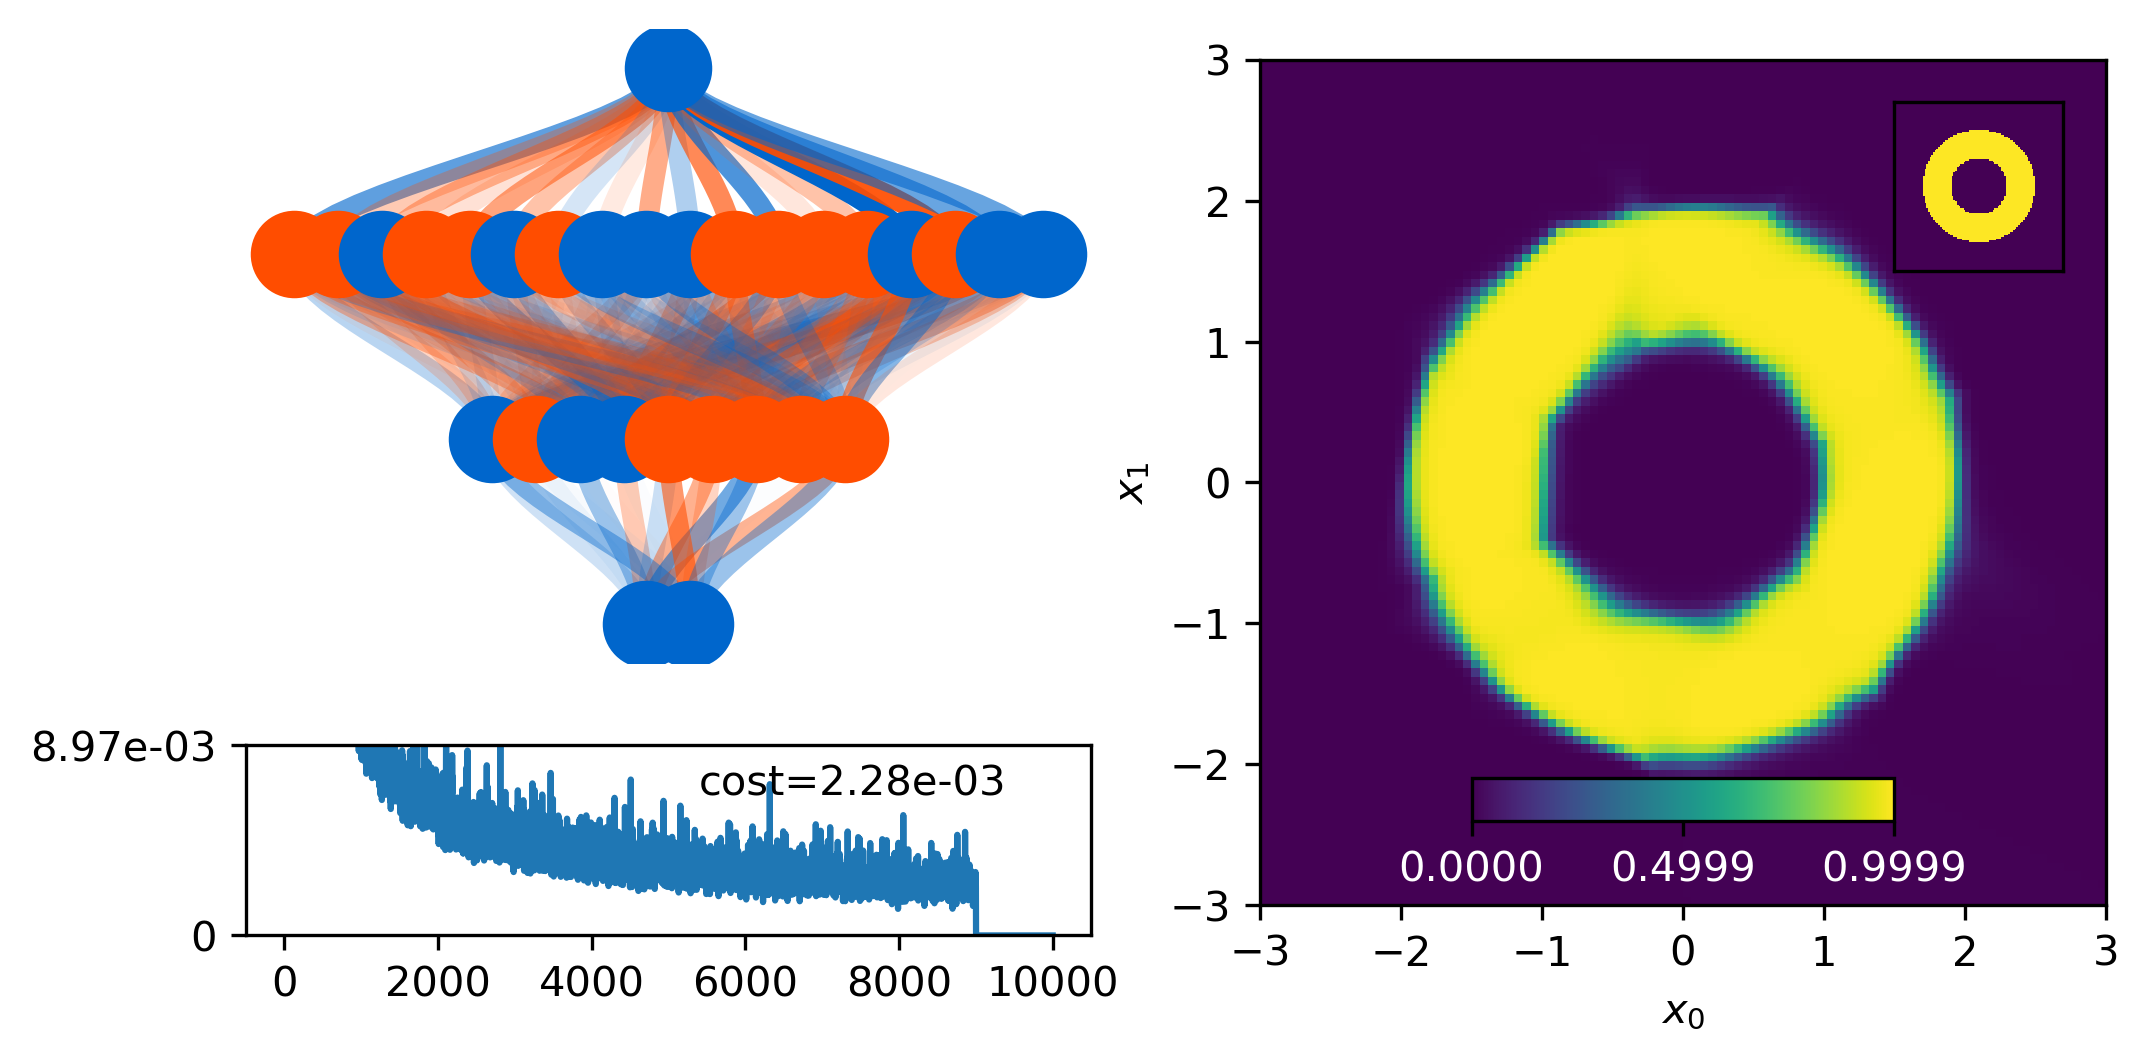

Summary Stats: Circle With Hole Run 5

Cost function: 0.0030224995111076737
Network Complexity (fit parameters): 226
Execution Time (s): 39.28028356699997


In [24]:
run_name = "Circle With Hole Run 5"
num_n = [2,9,18,1]
bias_s = 1
weight_s = 1
target_f=circle_hole_target
act = ['reLU','sigmoid', 'sigmoid', 'sigmoid',]
st = 10000
et = 4
batchs = 2000
visual = 1000
run_training(run_name, num_n, bias_s, weight_s, target_f, act, st, et, batchs)

# Discussion
Best fit came with 2 equal hidden layers. This was used. It was tested with narrower inner layers (12,12) but this gave a poor fit >0.004. Instead, steps and batches were decreased to get a fit <0.004, a threshold we had used previously.

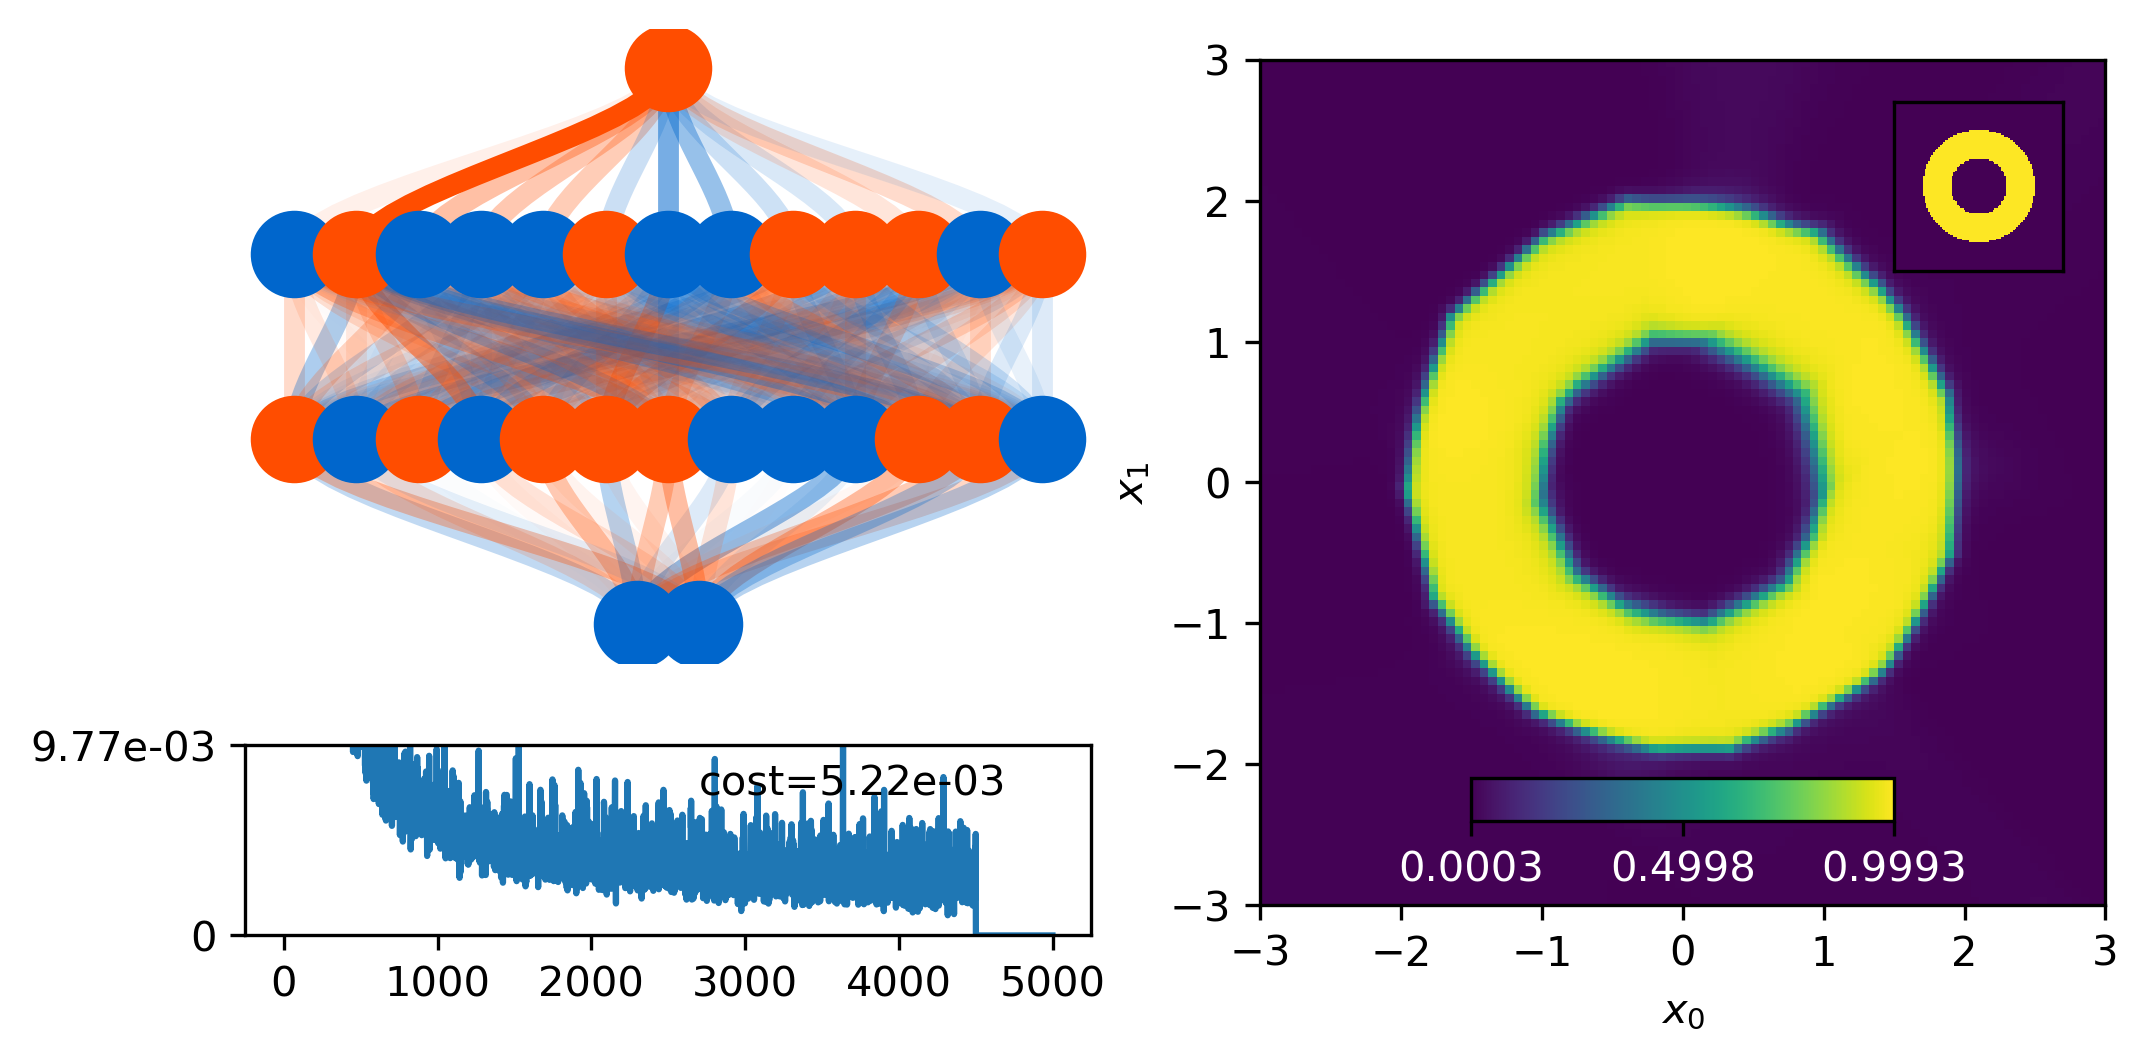

Summary Stats: Circle With Hole Run 6

Cost function: 0.00303202600089522
Network Complexity (fit parameters): 235
Execution Time (s): 20.90963852899995


In [25]:
run_name = "Circle With Hole Run 6"
num_n = [2,13,13,1]
bias_s = 1
weight_s = 1
target_f=circle_hole_target
act = ['reLU','sigmoid', 'sigmoid', 'sigmoid',]
st = 5000
et = 4
batchs = 1000
visual = 500
run_training(run_name, num_n, bias_s, weight_s, target_f, act, st, et, batchs)

# Discussion
As compared to the circle target, the circle with hole target was best trained with two layers instead of one. It was pleasing to able to reduce down execution time significantly, by altering some of the parameters and still getting a decent fit (<0.004). The parameters in Circle with Hole Run 6 represent the selected training parameters. 

## Scream target [20 points]
Train a network to mimic the following target (e.g. using the visualize_network_training function above). Note this target is much more difficult than the previous two.

In [26]:
def scream_target(x): #A circle of radius 2, two eyes of radius 0.5 and a mouth of radius 0.8
    a=0.8; r=0.5; R=2.0; r2=0.8
    return( 1.0*( x[:,0]**2+x[:,1]**2<R**2 ) - 1.0*( (x[:,0]-a)**2+(x[:,1]-a)**2<r**2) - 1.0*( (x[:,0]+a)**2+(x[:,1]-a)**2<r**2 ) - 1.0*( (x[:,0])**2+(x[:,1]+a)**2<r2**2 ) )

# Discussion
Here the same starting point as "circle with hole" was used and it was pleasing to see an approximation of the target with all the right features.

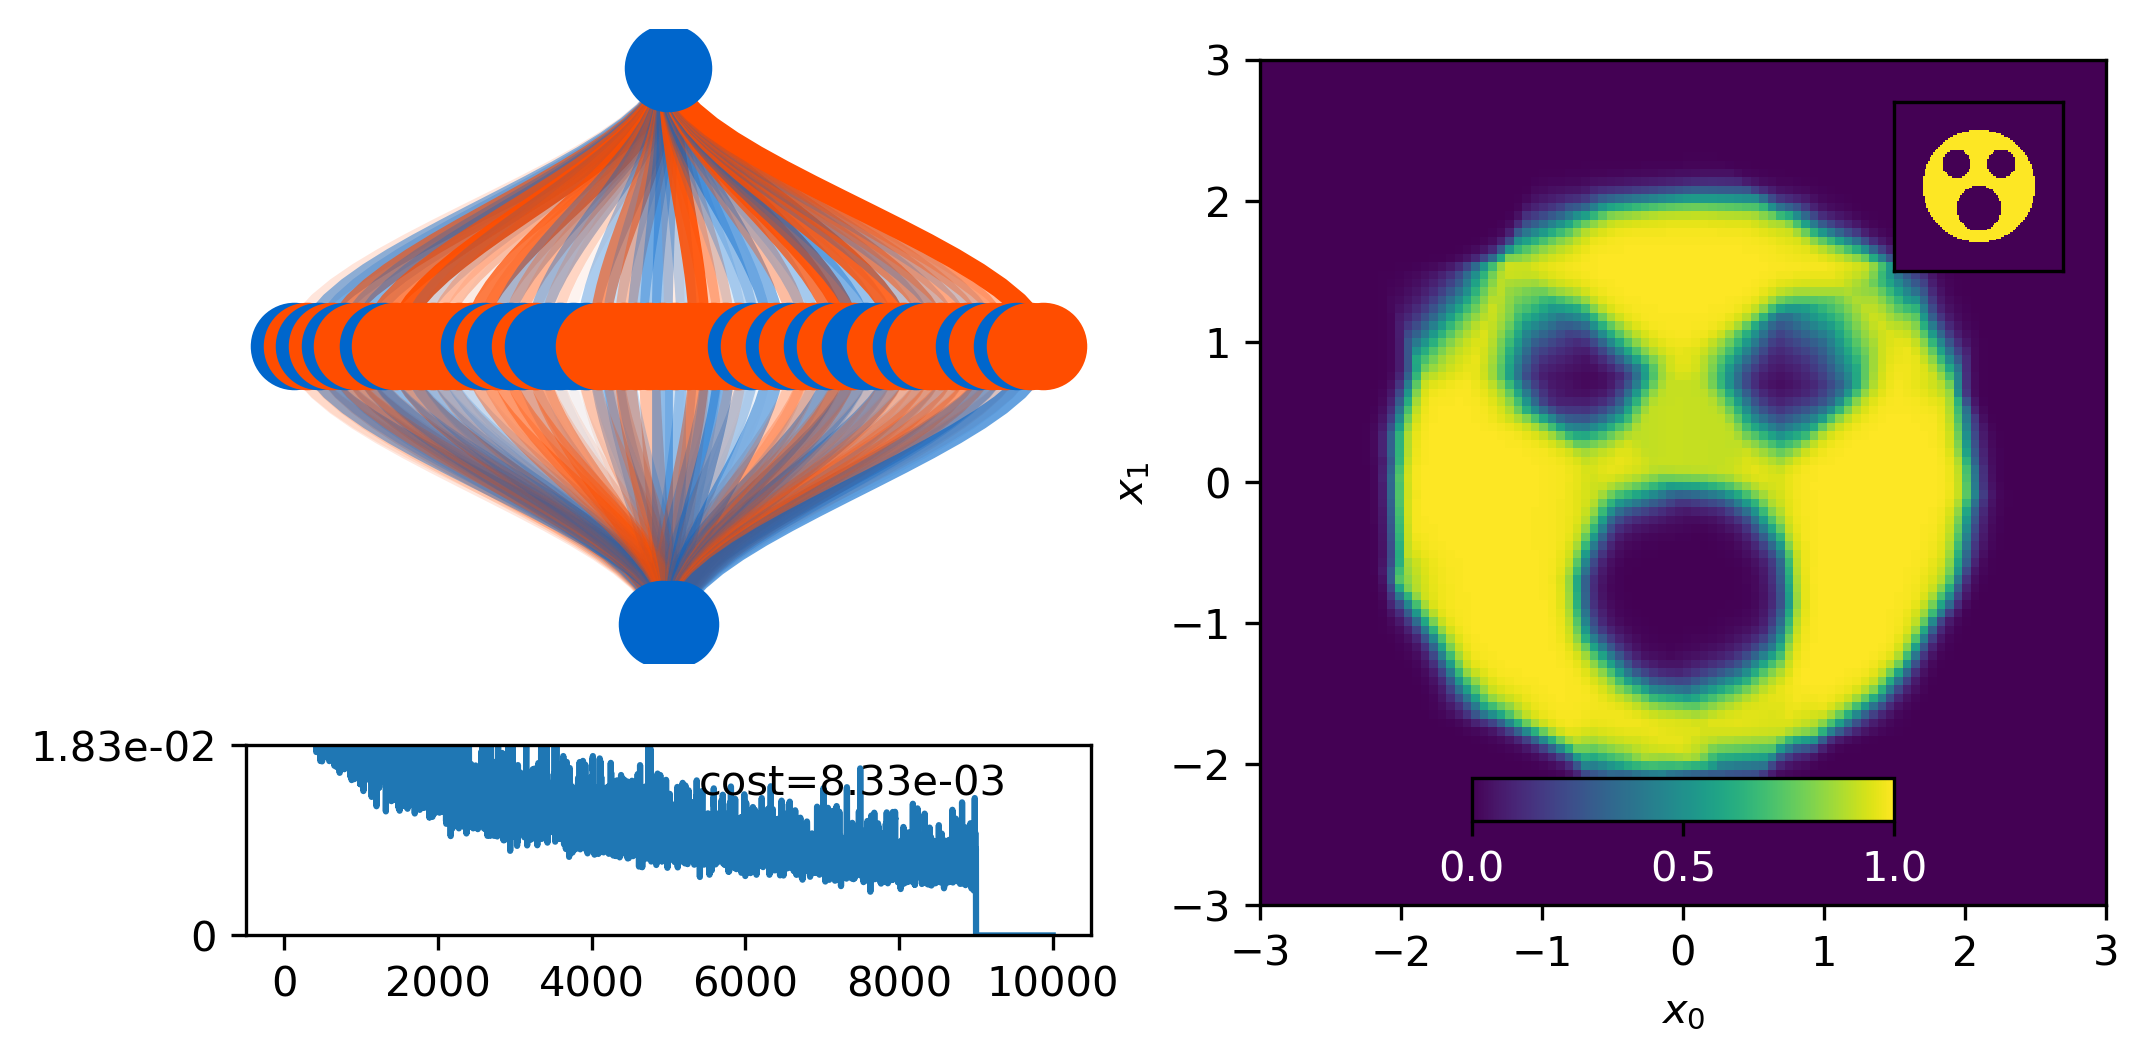

Summary Stats: Scream Run 1

Cost function: 0.004588116450224634
Network Complexity (fit parameters): 241
Execution Time (s): 35.16815295799995


In [27]:
run_name = "Scream Run 1"
num_n = [2,60,1]
bias_s = 1
weight_s = 1
target_f=scream_target
act = ['reLU','sigmoid']
st = 10000
et = 4
batchs = 2000
visual = 1000
run_training(run_name, num_n, bias_s, weight_s, target_f, act, st, et, batchs)

# Discussion
It was noted that the circle with hole target was best trained with 2 layers. Here there were even more features, so perhaps a multi-layer approach would work best. First it was tested with 3 equal layers, then 4 and lastly with 2.

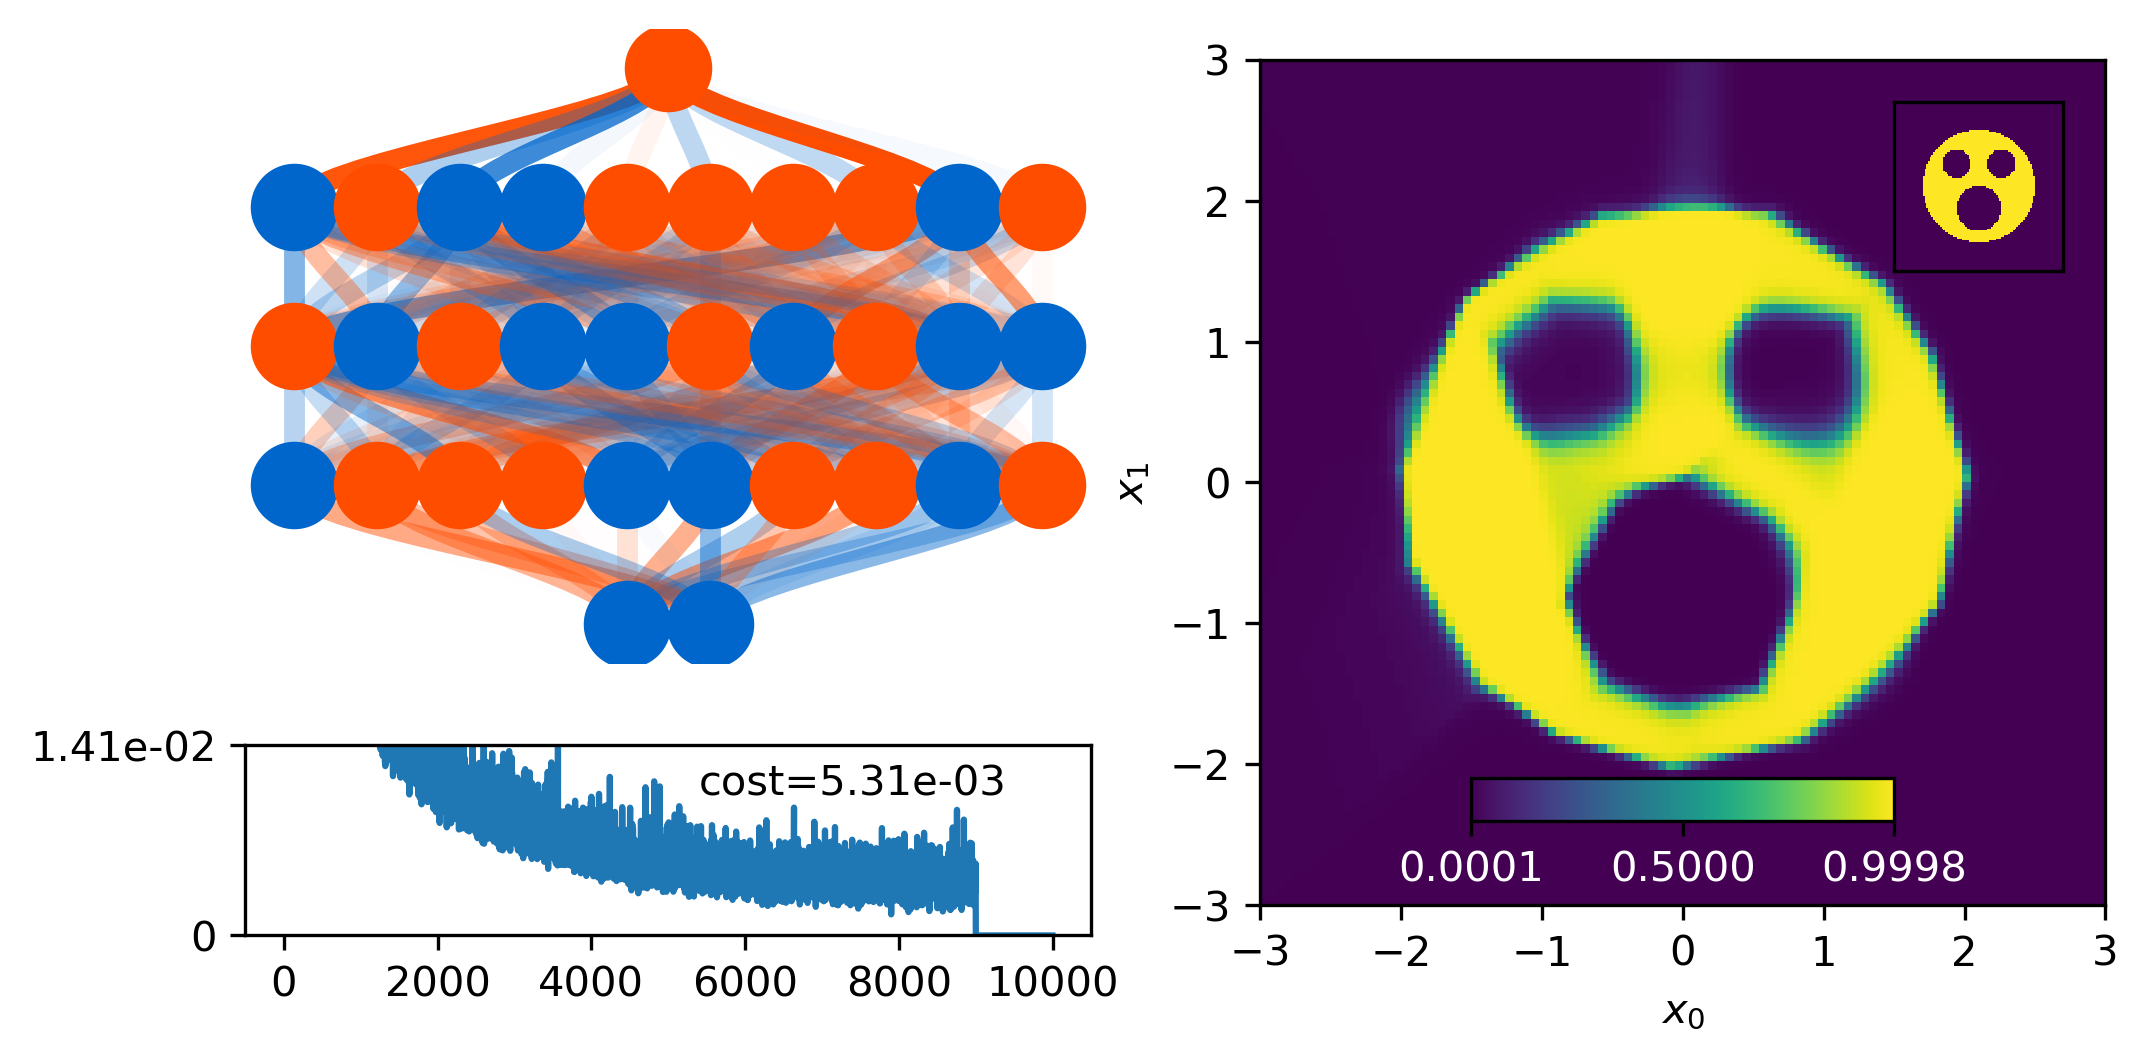

Summary Stats: Scream Run 2

Cost function: 0.0038330307870877356
Network Complexity (fit parameters): 261
Execution Time (s): 48.97514298299984


In [31]:
run_name = "Scream Run 2"
num_n = [2,10,10,10,1]
bias_s = 1
weight_s = 1
target_f=scream_target
act = ['reLU','sigmoid', 'sigmoid', 'sigmoid',]
st = 10000
et = 4
batchs = 2000
visual = 1000
run_training(run_name, num_n, bias_s, weight_s, target_f, act, st, et, batchs)

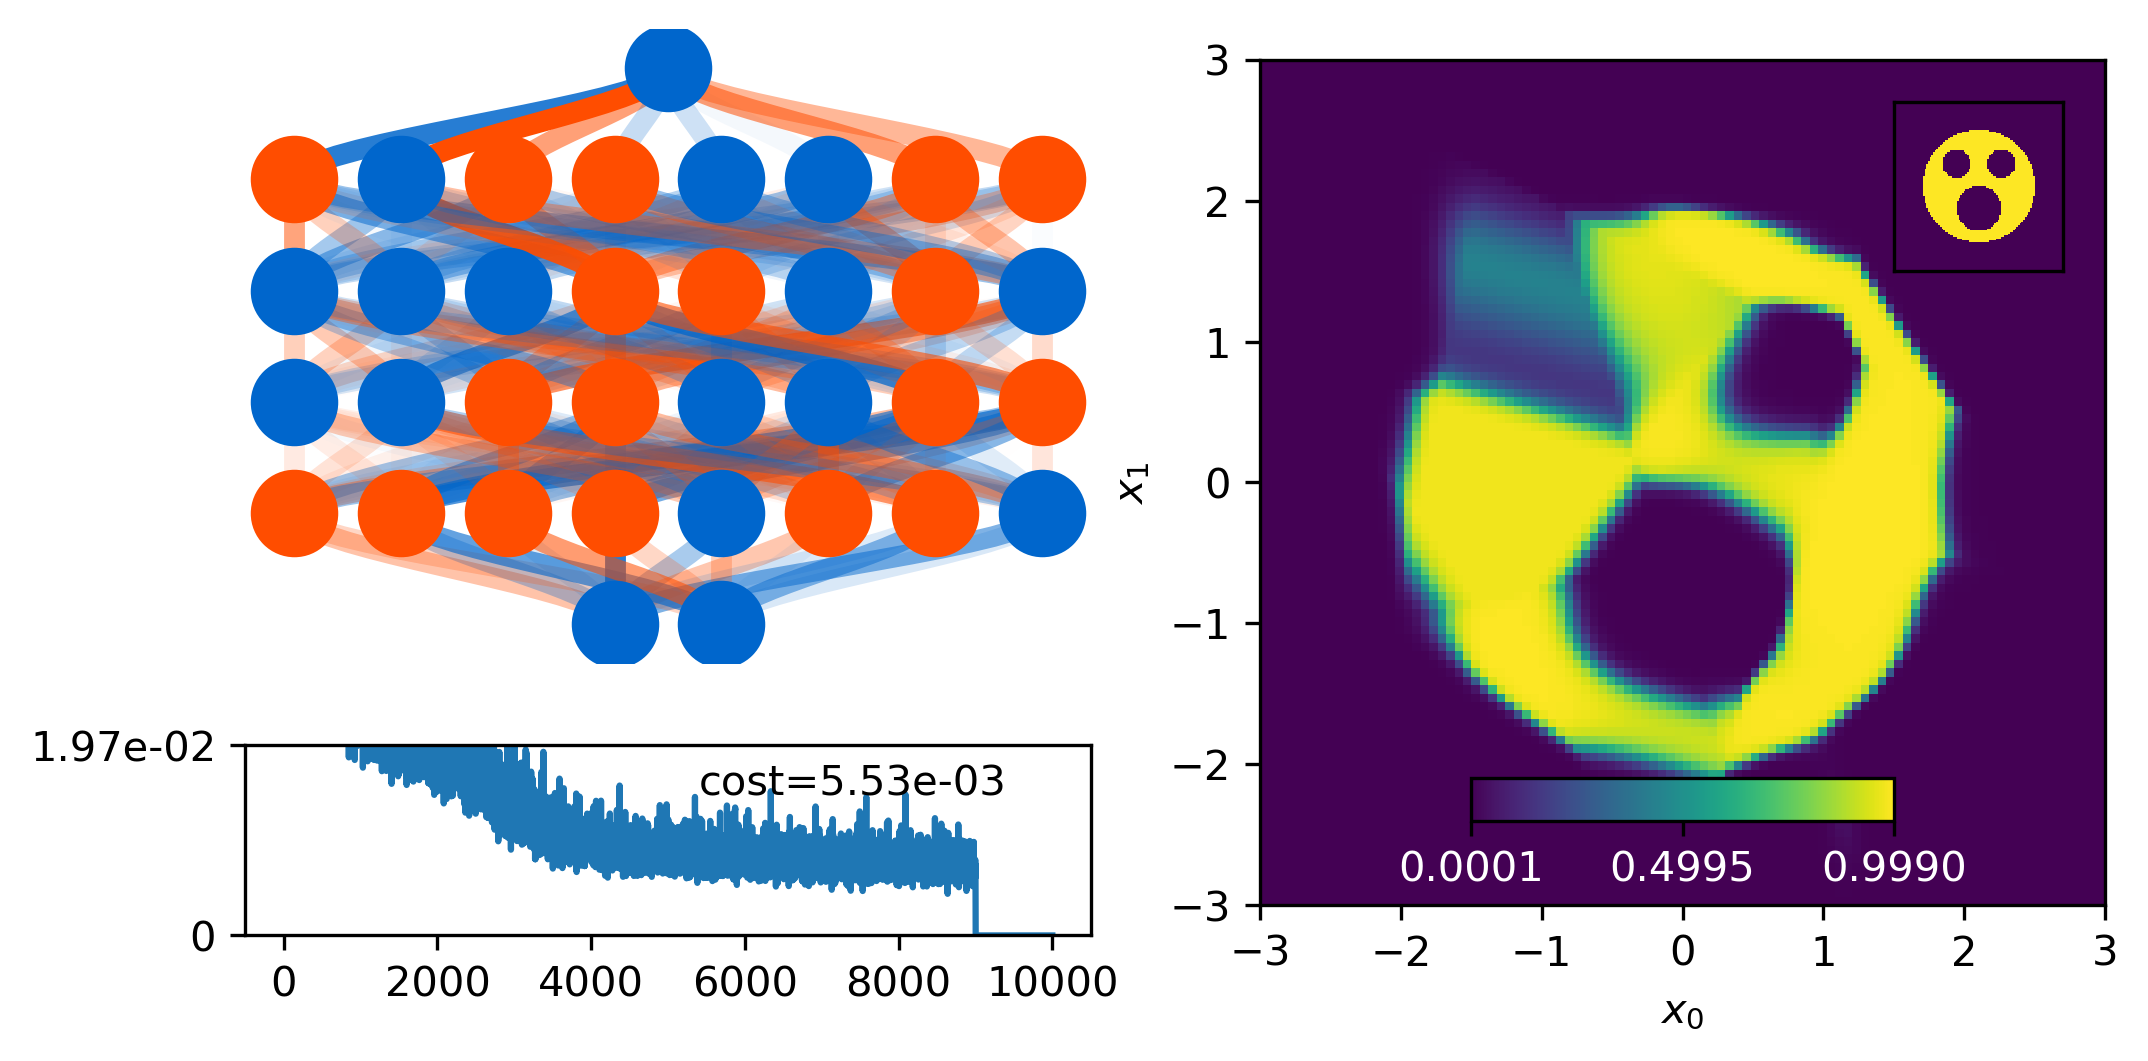

Summary Stats: Scream Run 3

Cost function: 0.008519192404743206
Network Complexity (fit parameters): 249
Execution Time (s): 49.419201409999914


In [29]:
run_name = "Scream Run 3"
num_n = [2,8,8,8,8,1]
bias_s = 1
weight_s = 1
target_f=scream_target
act = ['reLU','sigmoid', 'sigmoid', 'sigmoid','sigmoid']
st = 10000
et = 4
batchs = 2000
visual = 1000
run_training(run_name, num_n, bias_s, weight_s, target_f, act, st, et, batchs)

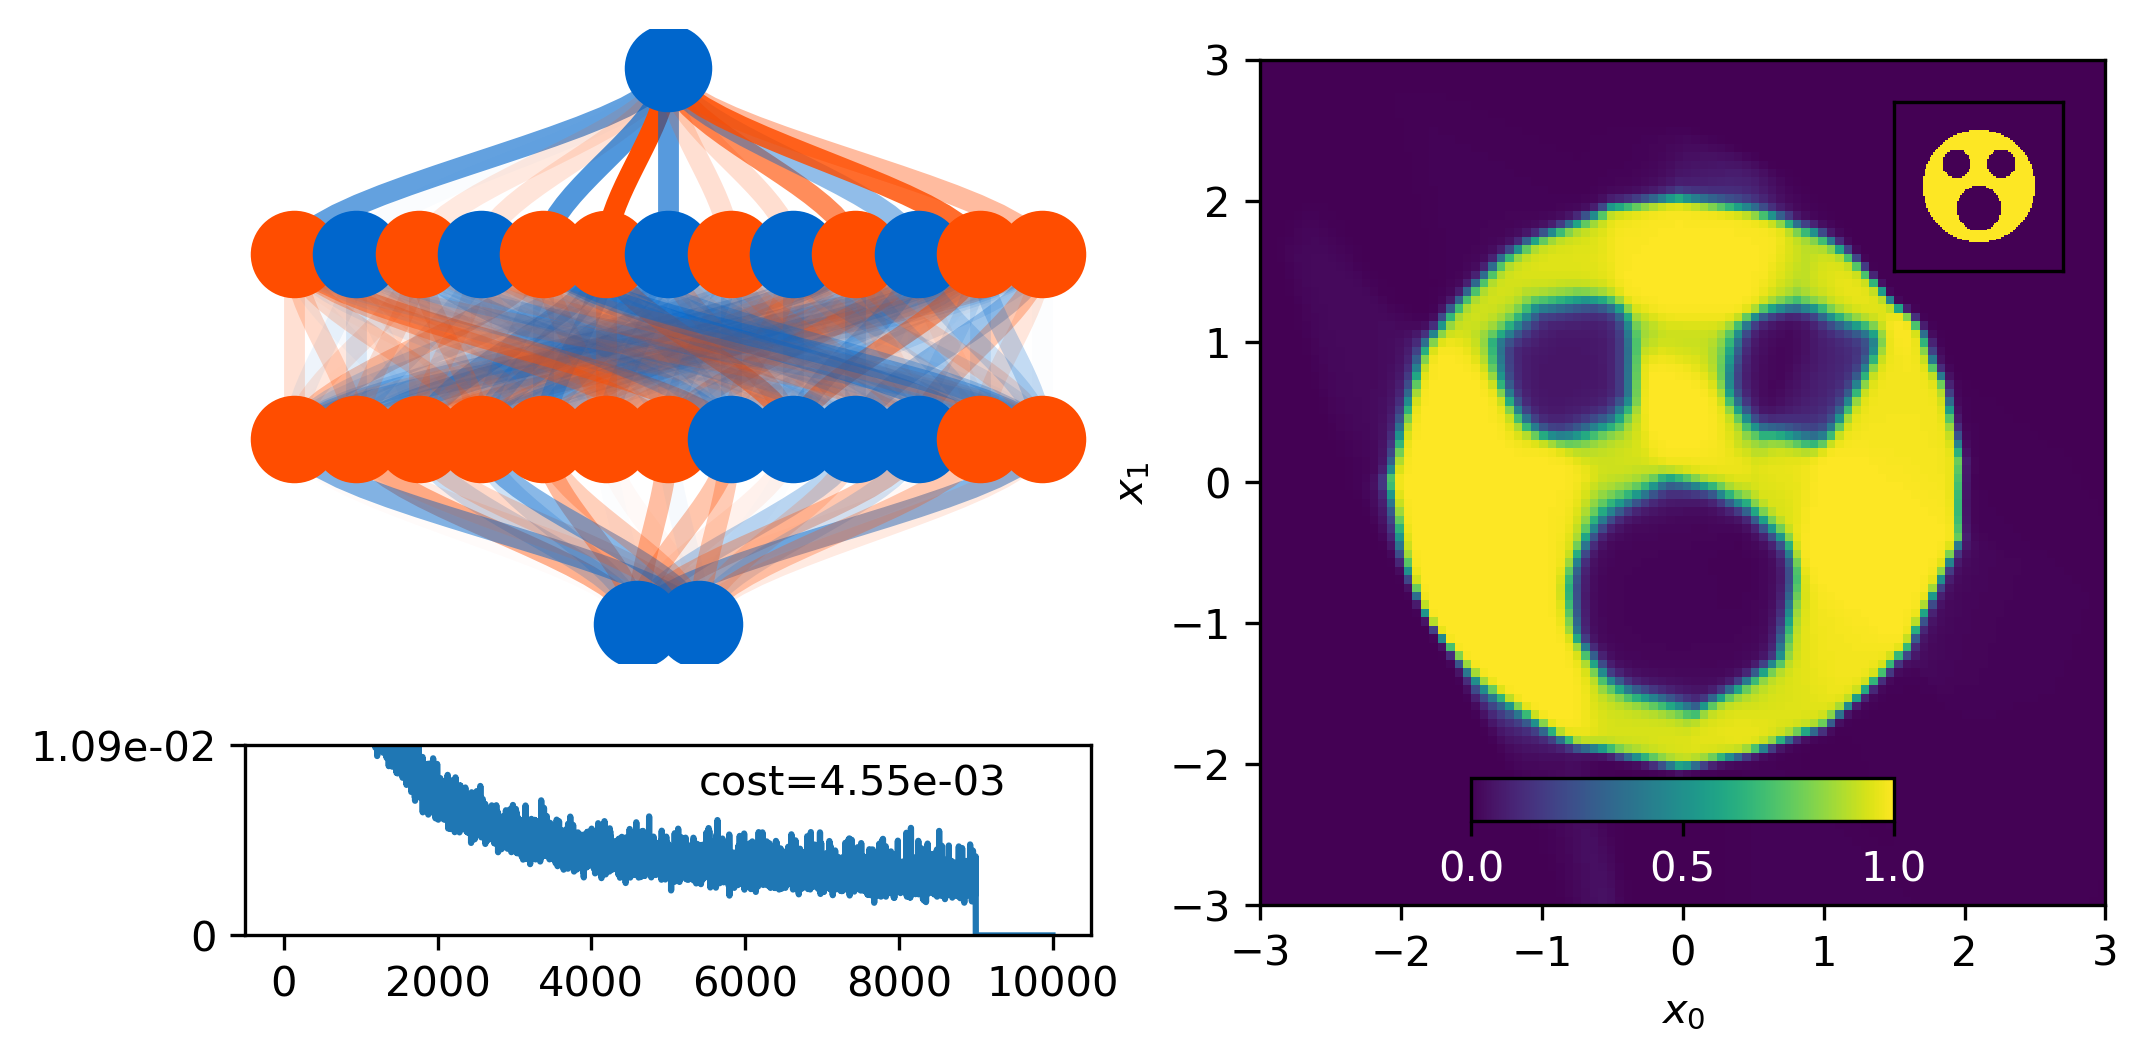

Summary Stats: Scream Run 4

Cost function: 0.0028972989468174786
Network Complexity (fit parameters): 235
Execution Time (s): 41.787389087000065


In [30]:
run_name = "Scream Run 4"
num_n = [2,13,13,1]
bias_s = 1
weight_s = 1
target_f=scream_target
act = ['reLU','sigmoid', 'sigmoid',]
st = 10000
et = 4
batchs = 2000
visual = 1000
run_training(run_name, num_n, bias_s, weight_s, target_f, act, st, et, batchs)

# Discussion
Unexpectedly, the best fit came from using two layers. As before, the widths were varied so firstly shown with first hidden layer twice as wide as second layer and then vice versa.

It seems that having narrow hidden layers makes it difficult to replicate circular shapes. Also the runs are quite variable, given the random assigned initial weights and biases. But generally, the best fit was from the 2 hidden layer network. 

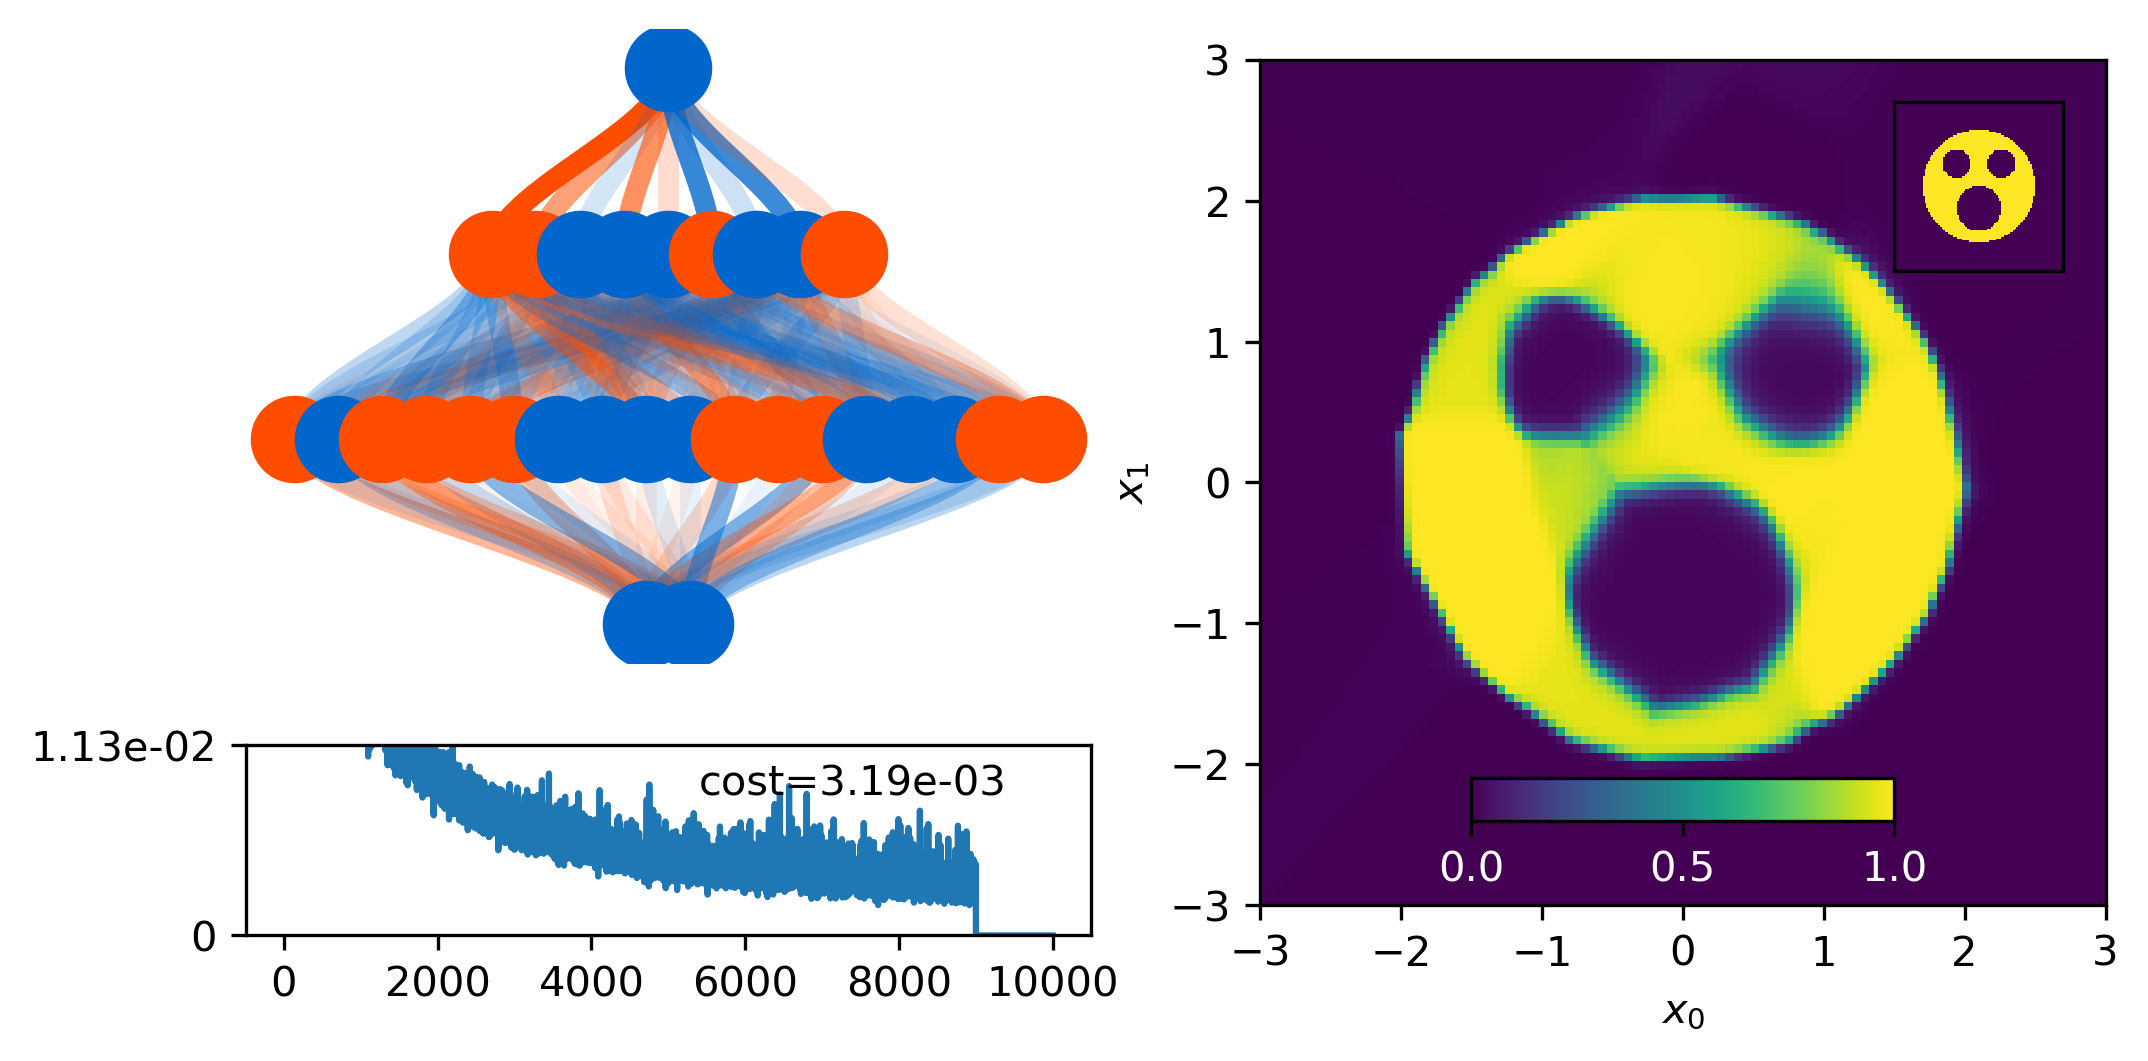

Summary Stats: Scream Run 5

Cost function: 0.003947933327570935
Network Complexity (fit parameters): 235
Execution Time (s): 37.73775369200007


In [32]:
run_name = "Scream Run 5"
num_n = [2,18,9,1]
bias_s = 1
weight_s = 1
target_f=scream_target
act = ['reLU','sigmoid', 'sigmoid',]
st = 10000
et = 4
batchs = 2000
visual = 1000
run_training(run_name, num_n, bias_s, weight_s, target_f, act, st, et, batchs)

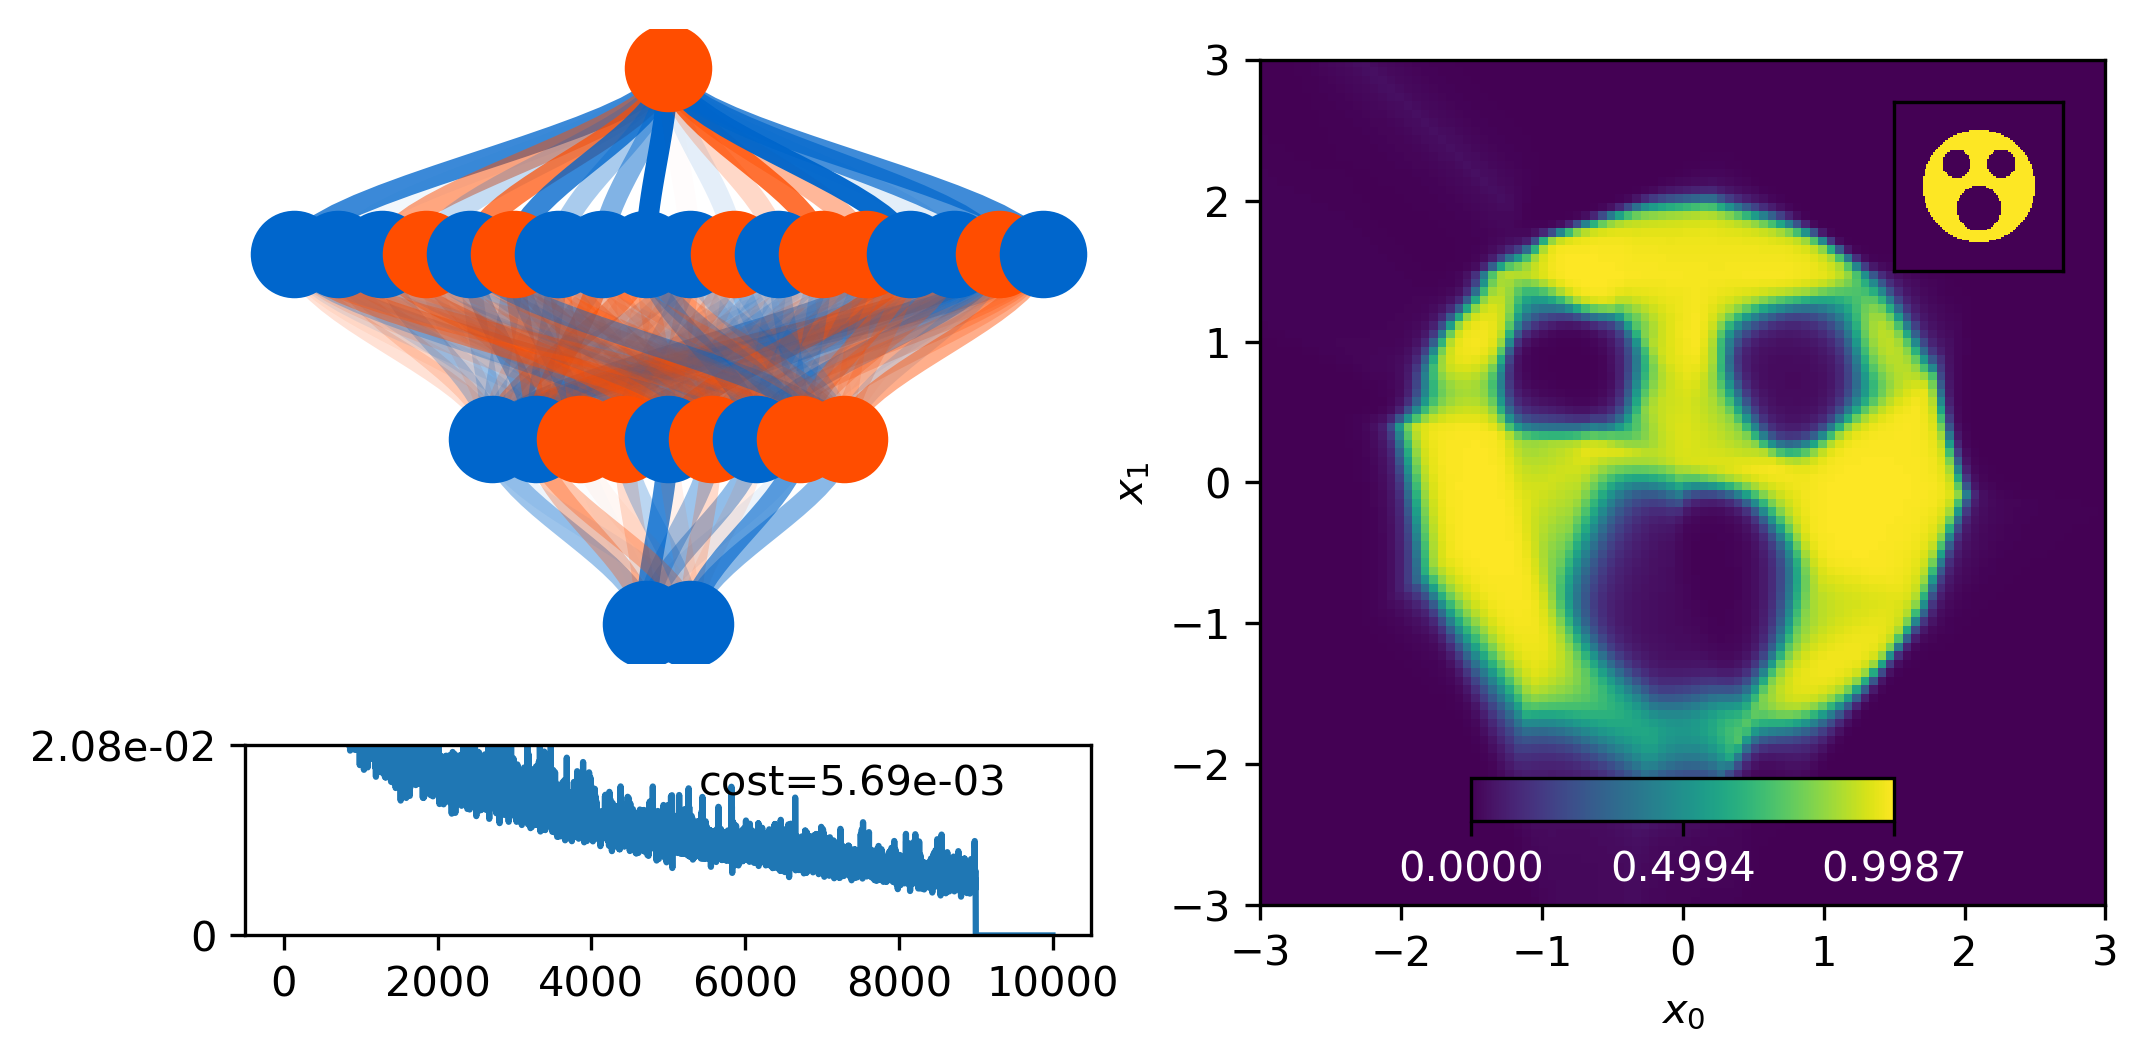

Summary Stats: Scream Run 6

Cost function: 0.004510271957349033
Network Complexity (fit parameters): 226
Execution Time (s): 40.958668821999936


In [33]:
run_name = "Scream Run 6"
num_n = [2,9,18,1]
bias_s = 1
weight_s = 1
target_f=scream_target
act = ['reLU','sigmoid', 'sigmoid',]
st = 10000
et = 4
batchs = 2000
visual = 1000
run_training(run_name, num_n, bias_s, weight_s, target_f, act, st, et, batchs)

# Discussion
Like circle with hole, the best result was for 2 inner layers with equal number of nodes. It was decided to use this set-up and try and optimise for the best trade-off between cost function, network complexity and execution time.  

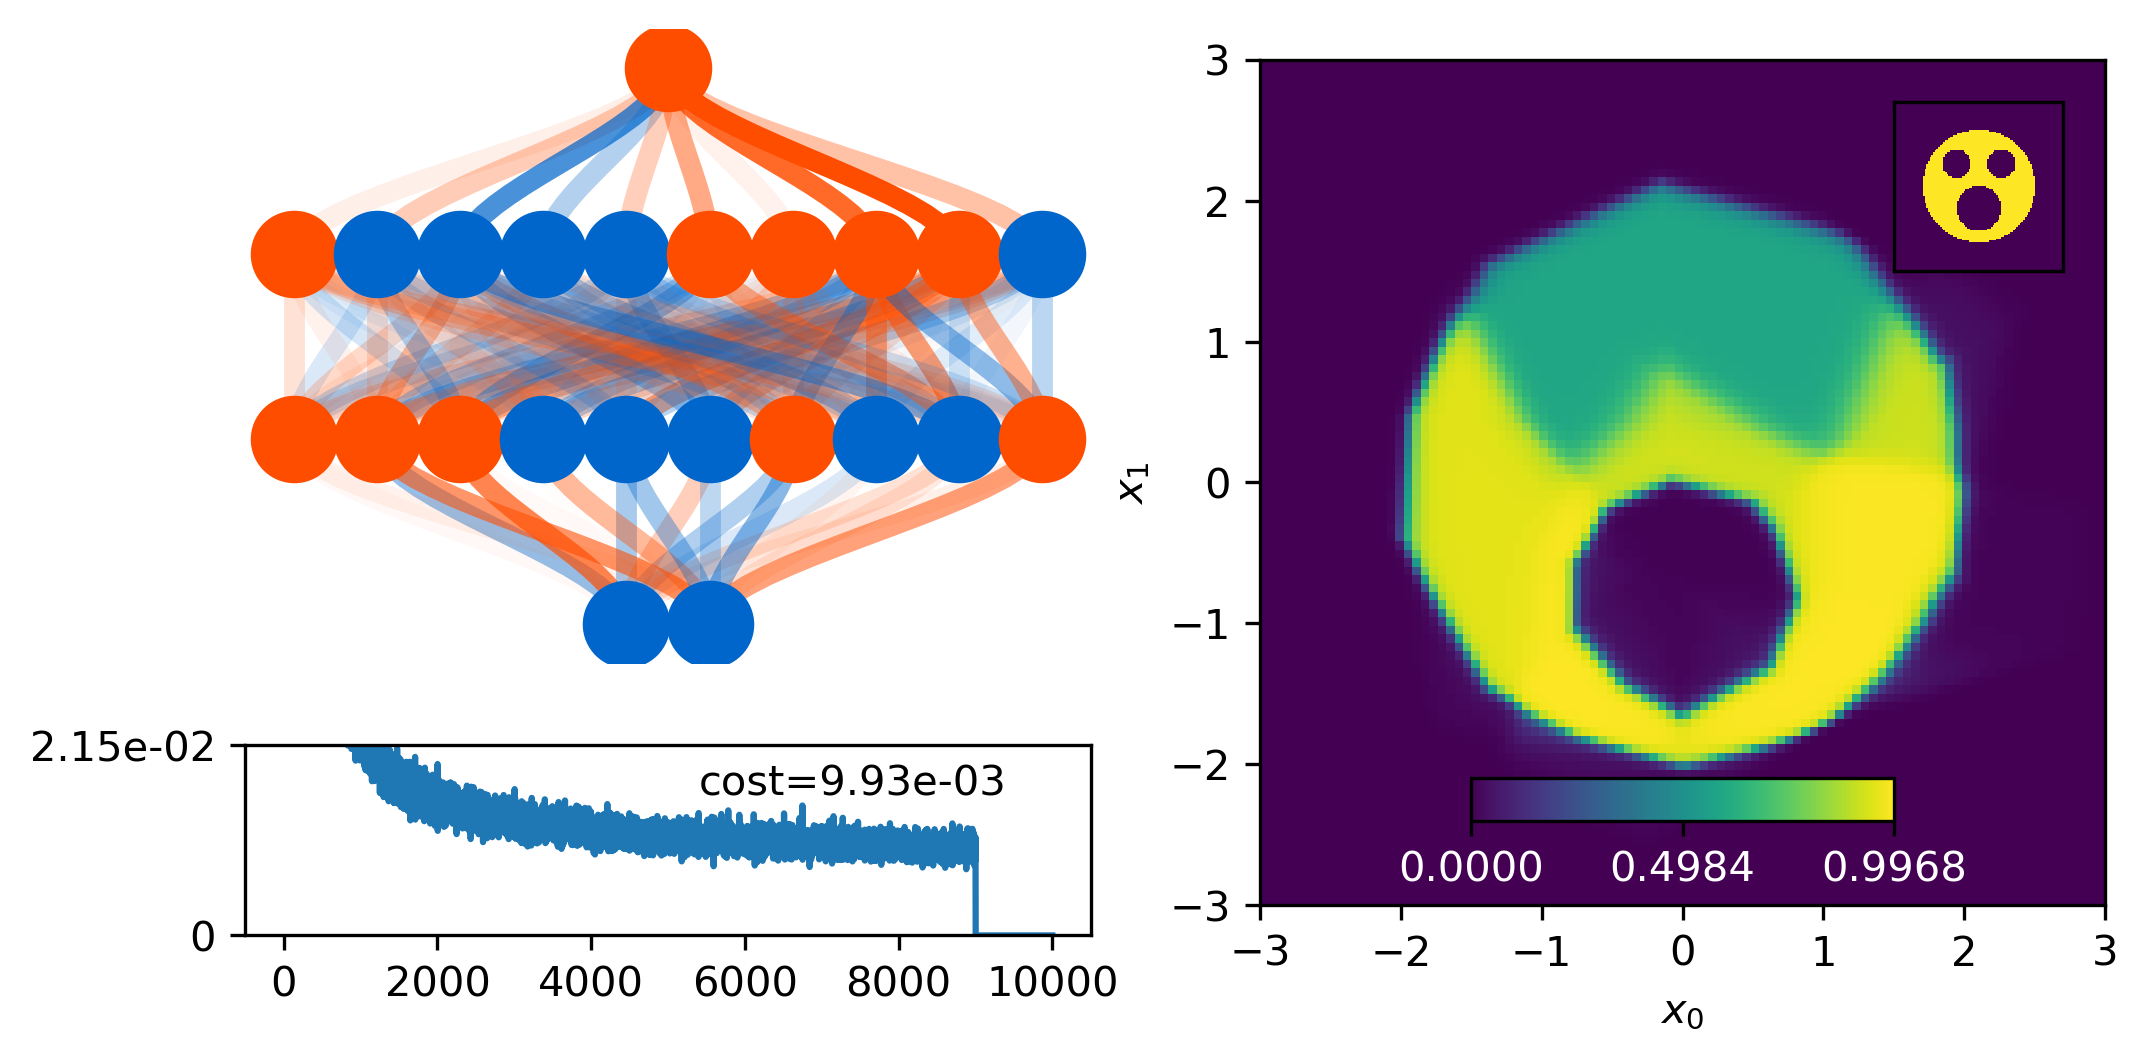

Summary Stats: Scream Run 7

Cost function: 0.011138193522766624
Network Complexity (fit parameters): 151
Execution Time (s): 32.34152430499989


In [34]:
run_name = "Scream Run 7"
num_n = [2,10,10,1]
bias_s = 1
weight_s = 1
target_f=scream_target
act = ['reLU','sigmoid', 'sigmoid',]
st = 10000
et = 4
batchs = 2000
visual = 1000
run_training(run_name, num_n, bias_s, weight_s, target_f, act, st, et, batchs)

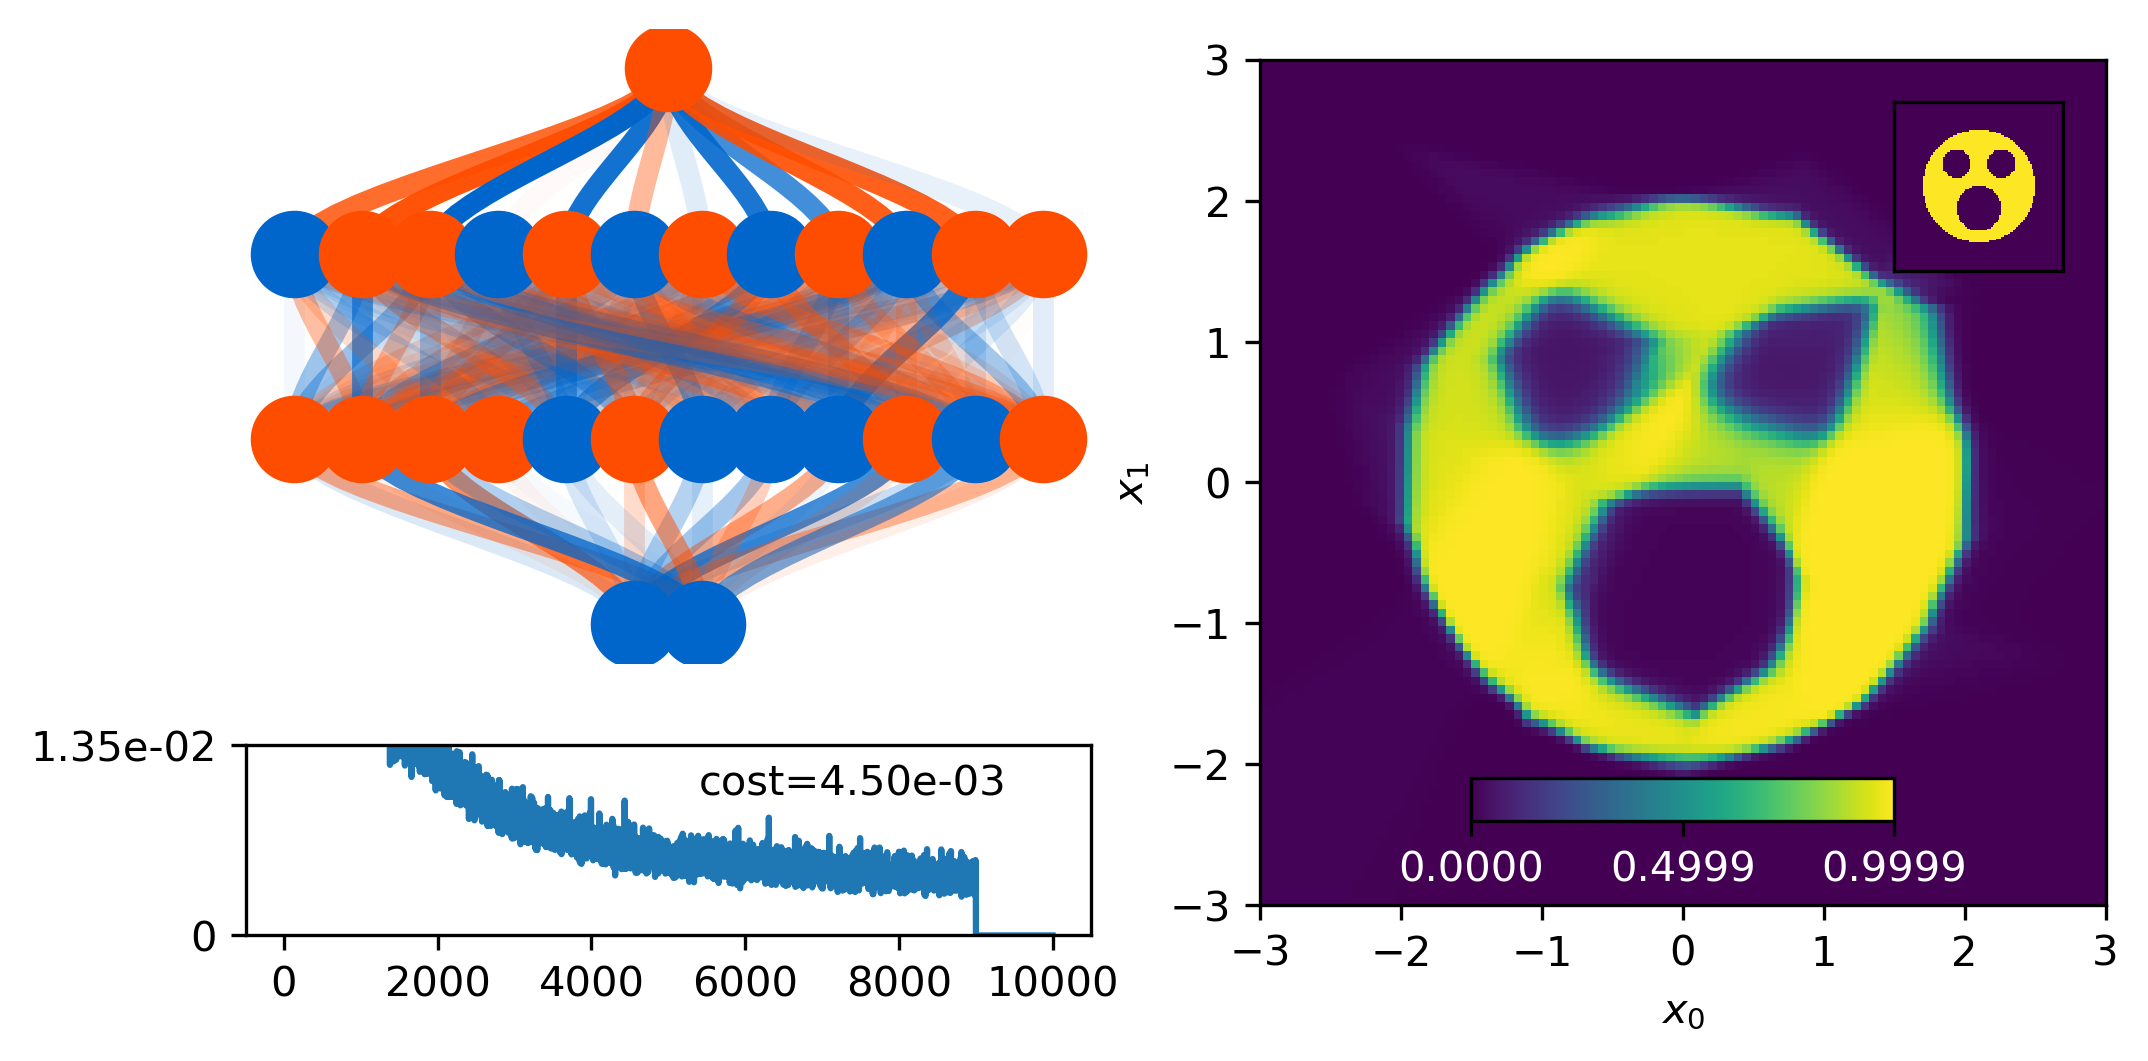

Summary Stats: Scream Run 8

Cost function: 0.0032470250479277735
Network Complexity (fit parameters): 205
Execution Time (s): 47.85489245500003


In [35]:
run_name = "Scream Run 8"
num_n = [2,12,12,1]
bias_s = 1
weight_s = 1
target_f=scream_target
act = ['reLU','sigmoid', 'sigmoid',]
st = 10000
et = 4
batchs = 2000
visual = 1000
run_training(run_name, num_n, bias_s, weight_s, target_f, act, st, et, batchs)

# Discussion
Using the threshold for cost function <0.004, it was not easy to reduce the width of the two layers without increasing number of steps/ reducing $\eta$ or increasing batch size. This would effect the execution times. Therefore it was decided to have the set up from Scream Run 4 as the selected one:

num_n = [2,13,13,1]
<p>bias_s = 1
<p>weight_s = 1
<p>target_f=scream_target
<p>act = ['reLU','sigmoid', 'sigmoid',]
<p>st = 10000
<p>et = 4
<p>batchs = 2000
<p>visual = 1000


# Summary Results
Training results of selected parameters

**Circle target - Run 11, one hidden layer 30 nodes** 
<p>Cost function: 0.002523481730328867
<P>Network Complexity (fit parameters): 121
<p>Execution Time (s): 11.552786803999993

**Circle with hole target - Run 6, two layers each 13 nodes**
Summary Stats: Circle With Hole Run 6
<p>Cost function: 0.0030320260008952
<p>Network Complexity (fit parameters): 235
<p>Execution Time (s): 20.90963852899995

**Scream target- Run 4, two layers each 13 nodes**
<p>Cost function: 0.0028972989468174786
<p>Network Complexity (fit parameters): 235
<p>Execution Time (s): 41.787389087000065



# Conclusions
Unsurprisingly, it took longer to fit the more complex targets: the scream took longer than the circle with hole and in turn the circle with hole took longer than the circle. It was not surprising to have to increase the network complexity for the circle with hole target, but it was interesting that this served well for the scream target as well - they had the same network set-ups. The scream target needed more steps and a longer time to get its cost function down to the right threshold.

In design of the training model, it is clear that there is a trade off between cost function desired and network complexity/ execution time. It was helpful to set an acceptable level of cost function so that the other two can be optimised.

As there were so many parameters, it might be useful to have a descent algorithm to help decide the optimal values! 